### Período 2

#### Importações

In [1]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kaleido"])

0

In [2]:
import pandas as pd
import re
import emoji
import nltk
import numpy as np
import string
from nltk.corpus import stopwords
from urllib.parse import urlparse
import emoji

stop_words_pt = set(stopwords.words('portuguese'))
punctuation = set(string.punctuation)

nltk.download('punkt')      
nltk.download('punkt_tab') 

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import networkx as nx

from networkx.algorithms import bipartite
from tqdm.auto import tqdm

from pyvis.network import Network
import matplotlib.colors as mcolors

import seaborn as sns
from bisect import bisect_right

import community.community_louvain as community_louvain # Requer: pip install python-louvain

import matplotlib

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Pre-Processamento

In [3]:
df = pd.read_csv("dataset_zap_2.csv", low_memory=False)

df = df.dropna(subset=["text_content_anonymous"]).copy()
df = df.reset_index(drop=True)

In [4]:
# Garante que as stopwords do NLTK foram baixadas
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# 1. LISTAS DE BLOQUEIO
# ------------------------------------------------------------------------------

# Vandalismo e Travas
crash_keywords = [
    "trava", "crash", "binario", "destrava", "imune", "rajada", 
    "virus", "clonagem", "hacker", "phoenix", "revaneio", "alien_monster", 
    "࿗", "꙰", "‮", "bòsta nà", "caráê", 
    "auto entitula logan", "raimundo",
    "harbyngers", "fish", "crown", "sun"
]

# Spam Comercial
spam_keywords = [
    "limpar nome", "aumentar score", "cnpj", "crédito", "empréstimo", 
    "venda", "oferta", "desconto", "turismo", "excursão", "saída", 
    "ganhe", "oportunidade", "renda extra", "marketing", "consórcio",
    "delivery", "entregamos", "promoção",
    "popcorn", "clapper_board", "antenna_bars",
    "melhores canais", "sua tv", "venha adquirir", "adquirir sua",
    "internet ilimitada", "conexão ilimitada", "sem travamentos",
    "filmes", "séries", "canais", "iptv", "tv box", "hbo", "telecine", 
    "INTERNET ILIMITADA", "Internet Ilimitada", "vivo", "tim", "oi", "Venha",
    "kwaivideocom",
    "muita gente falando sobre notícia",
    "notícia deixa triste", "triste", 
    "todos redor falando sobre notícia",
    "todos redor falando",
    "muita gente falando", "vive vez aproveite vida",
    "kwai", "kwaivideocom", "acho vai adorar", "divulguei", 
]

# Stopwords Personalizadas
custom_stopwords = {
    "bom", "dia", "boa", "tarde", "noite", "olá", "oi", "ola", "tchau",
    "kk", "kkk", "kkkk", "kkkkk", "rs", "rsrs", "aff", "eita", "oxi", "oxe",
    "imagem", "figura", "sticker", "áudio", "audio", "vídeo", "video",
    "mensagem", "encaminhada", "apagou", "pra", "pro", "tá", "pq", "vc"
}

# ------------------------------------------------------------------------------
# 2. Carrega as stopwords padrão (de, para, o, a, um, uns...)
nltk_stopwords = set(stopwords.words('portuguese'))

#Faz a UNIÃO dos dois conjuntos. 
stop_words_total = nltk_stopwords.union(custom_stopwords)

# 4. FUNÇÕES AUXILIARES

def is_junk_message(text_lower):
    """
    Retorna True se a mensagem for considerada Lixo (Spam, Trava ou Vandalismo)
    """
    if len(text_lower) > 3000:
        return True
    if any(term in text_lower for term in crash_keywords):
        return True
    if any(term in text_lower for term in spam_keywords):
        return True
    return False

def simplify_urls(text):
    """
    Substitui URLs completas apenas pelo domínio principal.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    def extract_domain(match):
        url = match.group(0)
        if not url.startswith('http'):
            url = 'http://' + url
        try:
            parsed = urlparse(url)
            domain = parsed.netloc
            return domain.replace('www.', '')
        except:
            return url 

    return url_pattern.sub(extract_domain, text)

In [5]:
# FUNÇÃO DE PRÉ-PROCESSAMENTO
# ------------------------------------------------------------------------------
def preprocess_text_final(text):
    # Check básico de tipo
    if not isinstance(text, str):
        return []
    
    # Normaliza para minúsculo
    text_lower = text.lower()

    # PASSO 1:função auxiliar para detectar LIXO rapidamente
    if is_junk_message(text_lower):
        return []

    # PASSO 2: Tratamento de URLs
    # Em vez de remover, simplifica para o domínio. 
    text = simplify_urls(text) 
    
    # PASSO 3: Limpeza de Emojis e Tokenização
    text = emoji.demojize(text) 
    
    # Remove pontuação antes de tokenizar para evitar tokens sujos
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = nltk.word_tokenize(text.lower())
    
    tokens_clean = []
    for token in tokens:
        # Remove se for stopword
        if token in stop_words_total: continue
        
        # Remove se for pontuação (redundância de segurança)
        if token in string.punctuation: continue
        
        # Remove tokens muito curtos (ex: "h", "1")
        if len(token) < 2: continue
        
        # Remove tokens que sobraram da demojização se não forem úteis
        if token.startswith(":") and token.endswith(":"):
             pass

        tokens_clean.append(token)
    
    return tokens_clean

print(">>> Iniciando pré-processamento...")
tqdm.pandas()

# Aplica a função
df['tokens_preprocessed'] = df['text_content_anonymous'].progress_apply(preprocess_text_final)

# PASSO: Remover mensagens que resultaram em menos de 2 tokens válidos
print(">>> Filtrando mensagens curtas (< 2 tokens úteis)...")

# Cria uma máscara booleana
mask_valid = df['tokens_preprocessed'].map(len) >= 2 

# Aplica o filtro
df_limpo = df[mask_valid].copy()

# Junta a lista ['ola', 'mundo'] na string "ola mundo" para o TF-IDF
df_limpo['clean_text'] = df_limpo['tokens_preprocessed'].apply(lambda x: " ".join(x))

# Resetar índice (alinhar com a matriz esparsa do TF-IDF depois)
df_limpo = df_limpo.reset_index(drop=True)

# Atualiza variáveis globais
df = df_limpo
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
N = len(df)

qtde_removida = len(df) - len(df_limpo)
print(f"Linhas removidas (Spam / Lixo / Curtas): {qtde_removida}")
print(f"Tamanho FINAL para análise: {len(df_limpo)}")



# 5. VERIFICAÇÃO E SALVAMENTO
print("\n>>> Amostra do Resultado Final:")
print(df_limpo[['text_content_anonymous', 'clean_text']].head(5))

print("\n>>> Salvando arquivo...")
df_limpo.to_csv("dataset_zap_2_preprocessado.csv", index=False, encoding='utf-8-sig')
print("Arquivo 'dataset_zap_2_preprocessado.csv' salvo com sucesso!")

df = df_limpo

>>> Iniciando pré-processamento...


  0%|          | 0/276748 [00:00<?, ?it/s]

>>> Filtrando mensagens curtas (< 2 tokens úteis)...
Linhas removidas (Spam / Lixo / Curtas): 0
Tamanho FINAL para análise: 150074

>>> Amostra do Resultado Final:
                              text_content_anonymous  \
0  *Filha de Michelle se manifesta após resultado...   
1  tem q pedir intervenção militar federal com ma...   
2  *PESSOAL O "ARTIGO 142" DIZ QUE O PRESIDENTE T...   
3  *Paralização, movimento de caminhoneiros em Ju...   
4  Bancada do PL se consolida como maior no Senad...   

                                          clean_text  
0  filha michelle manifesta após resultado urnas ...  
1  pedir intervenção militar federal manutenção p...  
2  pessoal artigo 142 diz presidente ficar 72h ca...  
3  paralização movimento caminhoneiros juiz mg in...  
4  bancada pl consolida maior senado terrabrasiln...  

>>> Salvando arquivo...
Arquivo 'dataset_zap_2_preprocessado.csv' salvo com sucesso!


In [6]:
print(">>> Preparando vetores para o Motor de Detecção...")

# 1. CONVERSÃO DE DATA
if not pd.api.types.is_datetime64_any_dtype(df['date_message']):
    print("Convertendo coluna de datas para datetime...")
    df['date_message'] = pd.to_datetime(df['date_message'], errors='coerce')

# Remove linhas onde a data falhou (NaT)
df = df.dropna(subset=['date_message']).copy()

# 2. ORDENAÇÃO TEMPORAL (OBRIGATÓRIO PARA JANELA DESLIZANTE)
# A lógica de "Rapid Spread" exige que os dados estejam em ordem cronológica
# para que o algoritmo pare de procurar assim que passar de 60s.
print("Ordenando dataset por data...")
df = df.sort_values(by='date_message', ascending=True).reset_index(drop=True)

# 3. CRIAÇÃO DAS LISTAS FINAIS
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
users = df["id_member_anonymous"].tolist() 
groups = df["id_group_anonymous"].tolist() 
N = len(df)

print(f"Total de mensagens: {N}")
print(f"Intervalo temporal: de {df['date_message'].min()} até {df['date_message'].max()}")

>>> Preparando vetores para o Motor de Detecção...
Convertendo coluna de datas para datetime...
Ordenando dataset por data...
Total de mensagens: 150074
Intervalo temporal: de 2022-11-01 00:00:00 até 2023-02-14 23:58:14


### Vetorização

In [7]:
# ==============================================================================
# ATUALIZAÇÃO DE LISTAS E VETORIZAÇÃO (TF-IDF)
# ==============================================================================
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

print(">>> [BLOCO 1] Atualizando listas e gerando Matriz TF-IDF...")

# 1.VARIÁVEIS
# listas sincronizadas pelo índice: Quem, O quê, Quando.
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
users = df["id_member_anonymous"].tolist() 
groups = df["id_group_anonymous"].tolist() 
N = len(df)

print(f"Dados atualizados: {N} mensagens para analisar.")

# 2. CONFIGURAR O VECTORIZER
# min_df=2: Remove palavras que aparecem em apenas 1 mensagem (erros de digitação/ruído único)
# dtype=np.float32: Reduz o consumo de memória RAM pela metade
vectorizer = TfidfVectorizer(min_df=2, dtype=np.float32) 

# 3. TRANSFORMAR TEXTO EM NÚMEROS
print("Vetorizando...")
X = vectorizer.fit_transform(texts)

# 4. OTIMIZAÇÃO (CSR)
X = X.tocsr()

print(f"Matriz TF-IDF gerada com sucesso: {X.shape}")
print(f"Vocabulário aprendido: {X.shape[1]} palavras únicas.")
print("(Linhas = Mensagens, Colunas = Palavras)")

>>> [BLOCO 1] Atualizando listas e gerando Matriz TF-IDF...
Dados atualizados: 150074 mensagens para analisar.
Vetorizando...
Matriz TF-IDF gerada com sucesso: (150074, 46710)
Vocabulário aprendido: 46710 palavras únicas.
(Linhas = Mensagens, Colunas = Palavras)


### Análise visual para definir tempo e similaridade

>>> [SONDAGEM] Coletando dados (Janela 60s | Similaridade > 0.0)...


Sondando:   0%|          | 0/30015 [00:00<?, ?it/s]

>>> Dados coletados: 40767 pares.


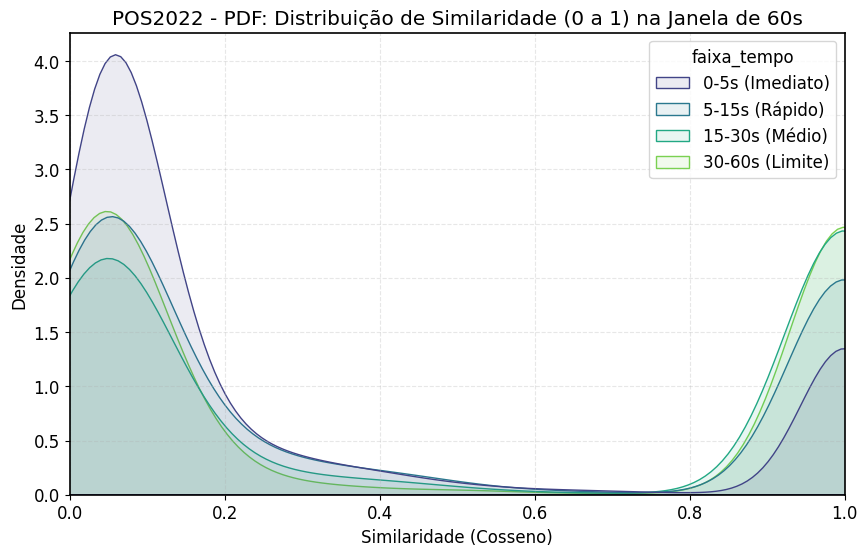

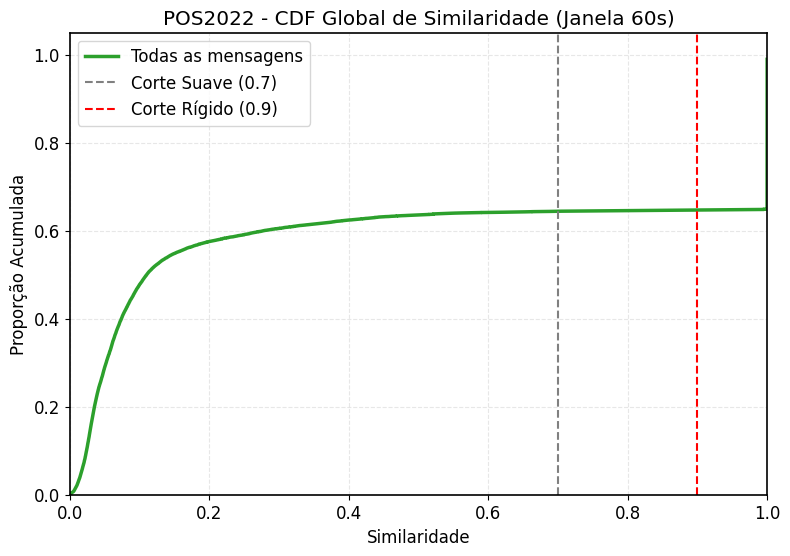

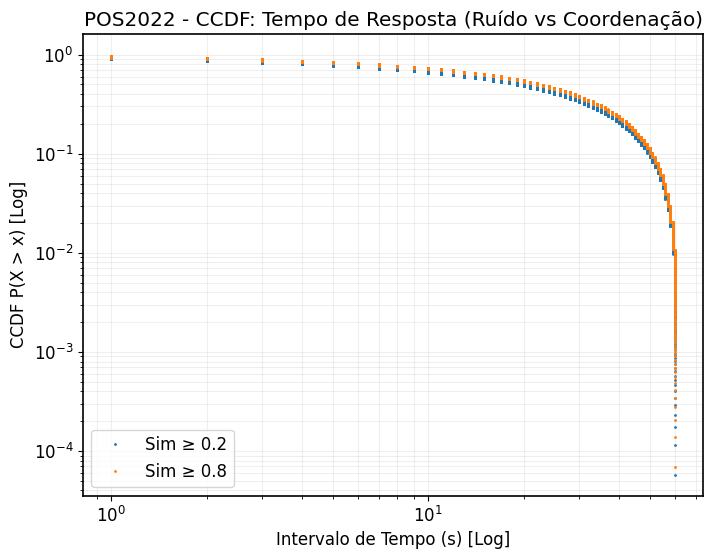

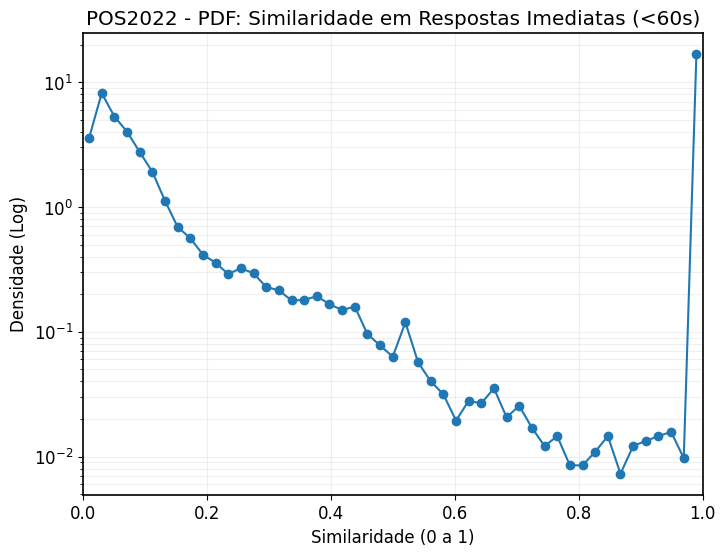

In [8]:
# SONDAGEM
print(">>> [SONDAGEM] Coletando dados (Janela 60s | Similaridade > 0.0)...")

def coletar_dados_sondagem_60s(max_window=60, min_sim=0.0):
    amostras = []
    time_window = pd.Timedelta(seconds=max_window)
    
    step = 1 if N < 50000 else 5 
    
    for i in tqdm(range(0, N - 1, step), desc="Sondando"):
        t_i = times[i]
        t_limit = t_i + time_window
        
        # Busca Binária para achar o fim da janela de 60s
        end_idx = bisect_right(times, t_limit, lo=i+1)
        if end_idx <= i + 1: continue
            
        # Bloco de comparação
        block = X[i+1 : end_idx]
        vec_i = X[i]
        
        # Cálculo vetorial
        sims = block.dot(vec_i.T).toarray().flatten()
        
        # Filtro (pegando tudo > 0 para ver a curva completa)
        valid_indices = np.where(sims > min_sim)[0]
        
        if len(valid_indices) > 0:
            global_indices = (i + 1) + valid_indices
            valid_sims = sims[valid_indices]
            for g_idx, s_val in zip(global_indices, valid_sims):
                dt = (times[g_idx] - t_i).total_seconds()
                amostras.append({"delta_t": dt, "similarity": float(s_val)})

    return pd.DataFrame(amostras)

# Rodar a coleta
df_sondagem = coletar_dados_sondagem_60s()

# ==============================================================================
# 2. PLOTAGEM BÁSICA (PDF & CDF)
# ==============================================================================
if not df_sondagem.empty:
    print(f">>> Dados coletados: {len(df_sondagem)} pares.")
    
    plt.rcParams.update({'font.size': 12, 'axes.linewidth': 1.2, 'grid.alpha': 0.3})

    # --- GRÁFICO 1: PDF (Densidade) ---
    plt.figure(figsize=(10, 6))
    
    # Faixas de tempo ajustadas para janela de 60s
    bins = [0, 5, 15, 30, 60]
    labels = ['0-5s (Imediato)', '5-15s (Rápido)', '15-30s (Médio)', '30-60s (Limite)']
    
    df_sondagem['faixa_tempo'] = pd.cut(df_sondagem['delta_t'], bins=bins, labels=labels)
    
    sns.kdeplot(
        data=df_sondagem, 
        x='similarity', 
        hue='faixa_tempo', 
        fill=True, 
        common_norm=False, 
        palette="viridis",
        alpha=0.1
    )
    
    plt.xlim(0.0, 1.0) 
    plt.title('POS2022 - PDF: Distribuição de Similaridade (0 a 1) na Janela de 60s')
    plt.xlabel('Similaridade (Cosseno)')
    plt.ylabel('Densidade')
    plt.grid(True, linestyle='--')
    plt.savefig("Grafico_PDF_0_a_1.png", dpi=300)
    plt.show()

    # --- GRÁFICO 2: CDF (Acumulação) ---
    plt.figure(figsize=(9, 6))
    
    # Ordenar por similaridade para ver a curva de crescimento
    sorted_sims = np.sort(df_sondagem['similarity'])
    yvals = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
    
    plt.plot(sorted_sims, yvals, color='#2ca02c', linewidth=2.5, label='Todas as mensagens')
    
    # Marcações visuais
    plt.axvline(0.7, color='gray', linestyle='--', label='Corte Suave (0.7)')
    plt.axvline(0.9, color='red', linestyle='--', label='Corte Rígido (0.9)')
    
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xlabel("Similaridade")
    plt.ylabel("Proporção Acumulada")
    plt.title("POS2022 - CDF Global de Similaridade (Janela 60s)")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.savefig("Grafico_CDF_Similaridade.png", dpi=300)
    plt.show()


    # --- GRÁFICO 3: CCDF Log-Log (Intervalos Temporais) ---
    plt.figure(figsize=(8, 6))
    
    # Compara similaridade baixa (ruído) vs alta (coordenação)
    for limiar in [0.2, 0.8]: 
        subset = df_sondagem[df_sondagem['similarity'] >= limiar]
        if not subset.empty:
            data_sorted = np.sort(subset['delta_t'])
            yvals = 1.0 - (np.arange(1, len(data_sorted) + 1) / len(data_sorted))
            plt.loglog(data_sorted, yvals, marker='.', linestyle='none', 
                       markersize=2, label=f'Sim ≥ {limiar}')
    
    plt.xlabel("Intervalo de Tempo (s) [Log]")
    plt.ylabel("CCDF P(X > x) [Log]")
    plt.title("POS2022 - CCDF: Tempo de Resposta (Ruído vs Coordenação)")
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)
    plt.savefig("Grafico_CCDF_Comparativo.png", dpi=300)
    plt.show()

    # --- GRÁFICO 4: PDF Semi-Log (Similaridade em Delta T curto) ---
    plt.figure(figsize=(8, 6))
    
    # Foco no "Immediate Spread" (<10s)
    df_short = df_sondagem[df_sondagem['delta_t'] <= 60]
    
    if not df_short.empty:
        # Histograma cobrindo 0 a 1
        hist, edges = np.histogram(df_short['similarity'], bins=np.linspace(0, 1, 50), density=True)
        centers = (edges[:-1] + edges[1:]) / 2
        
        plt.semilogy(centers, hist, marker='o', linestyle='-', color='#1f77b4')
        
        plt.xlabel("Similaridade (0 a 1)")
        plt.ylabel("Densidade (Log)")
        plt.title("POS2022 - PDF: Similaridade em Respostas Imediatas (<60s)")
        plt.xlim(0, 1)
        plt.grid(True, which="both", alpha=0.2)
        plt.savefig("Grafico_PDF_SemiLog_FullRange.png", dpi=300)
        plt.show()

else:
    print("Nenhum dado encontrado.")

### Interpretação

#### PDF

- Forte pico em similaridades baixas (≈ 0–0.2) -> Ruído / conversa normal de baixa similaridade

- Uma cauda longa até valores intermediários.

- Um novo crescimento abrupto próximo de 1.0: Coordenação explícita -> alta similaridade (quase cópia/paráfrase). O pico próximo de 1.0 não é natural em linguagem espontânea: Indica repostagem, templates, encaminhamentos ou mensagens fortemente padronizadas.


Quanto menor o Δt, maior a densidade no extremo alto (≈0.9–1.0). A janela 0–5s é a que mais concentra mensagens altamente similares. Forte indício de que a Coordenação semântica forte ocorre quase instantaneamente. À medida que o tempo passa, o conteúdo diverge mesmo quando há resposta.

Mesmo representando uma minoria dos pares, mensagens altamente similares concentram-se em janelas temporais curtas, caracterizando eventos de coordenação.

Os resultados revelam uma clara separação entre interações orgânicas e eventos de coordenação. Enquanto a maior parte das mensagens apresenta baixa similaridade textual, observa-se um subconjunto pequeno porém consistente de mensagens altamente similares, concentradas em janelas temporais extremamente curtas. Esse padrão é compatível com comportamentos coordenados, caracterizados por sincronização temporal e reutilização textual, e não pode ser explicado apenas por dinâmica conversacional espontânea.

Coletando offset +1:   0%|          | 0/150073 [00:00<?, ?it/s]

Coletando offset +2:   0%|          | 0/150072 [00:00<?, ?it/s]

Coletando offset +3:   0%|          | 0/150071 [00:00<?, ?it/s]

Coletando offset +4:   0%|          | 0/150070 [00:00<?, ?it/s]

Coletando offset +5:   0%|          | 0/150069 [00:00<?, ?it/s]

Coletando offset +10:   0%|          | 0/150064 [00:00<?, ?it/s]

Pares coletados: 900419


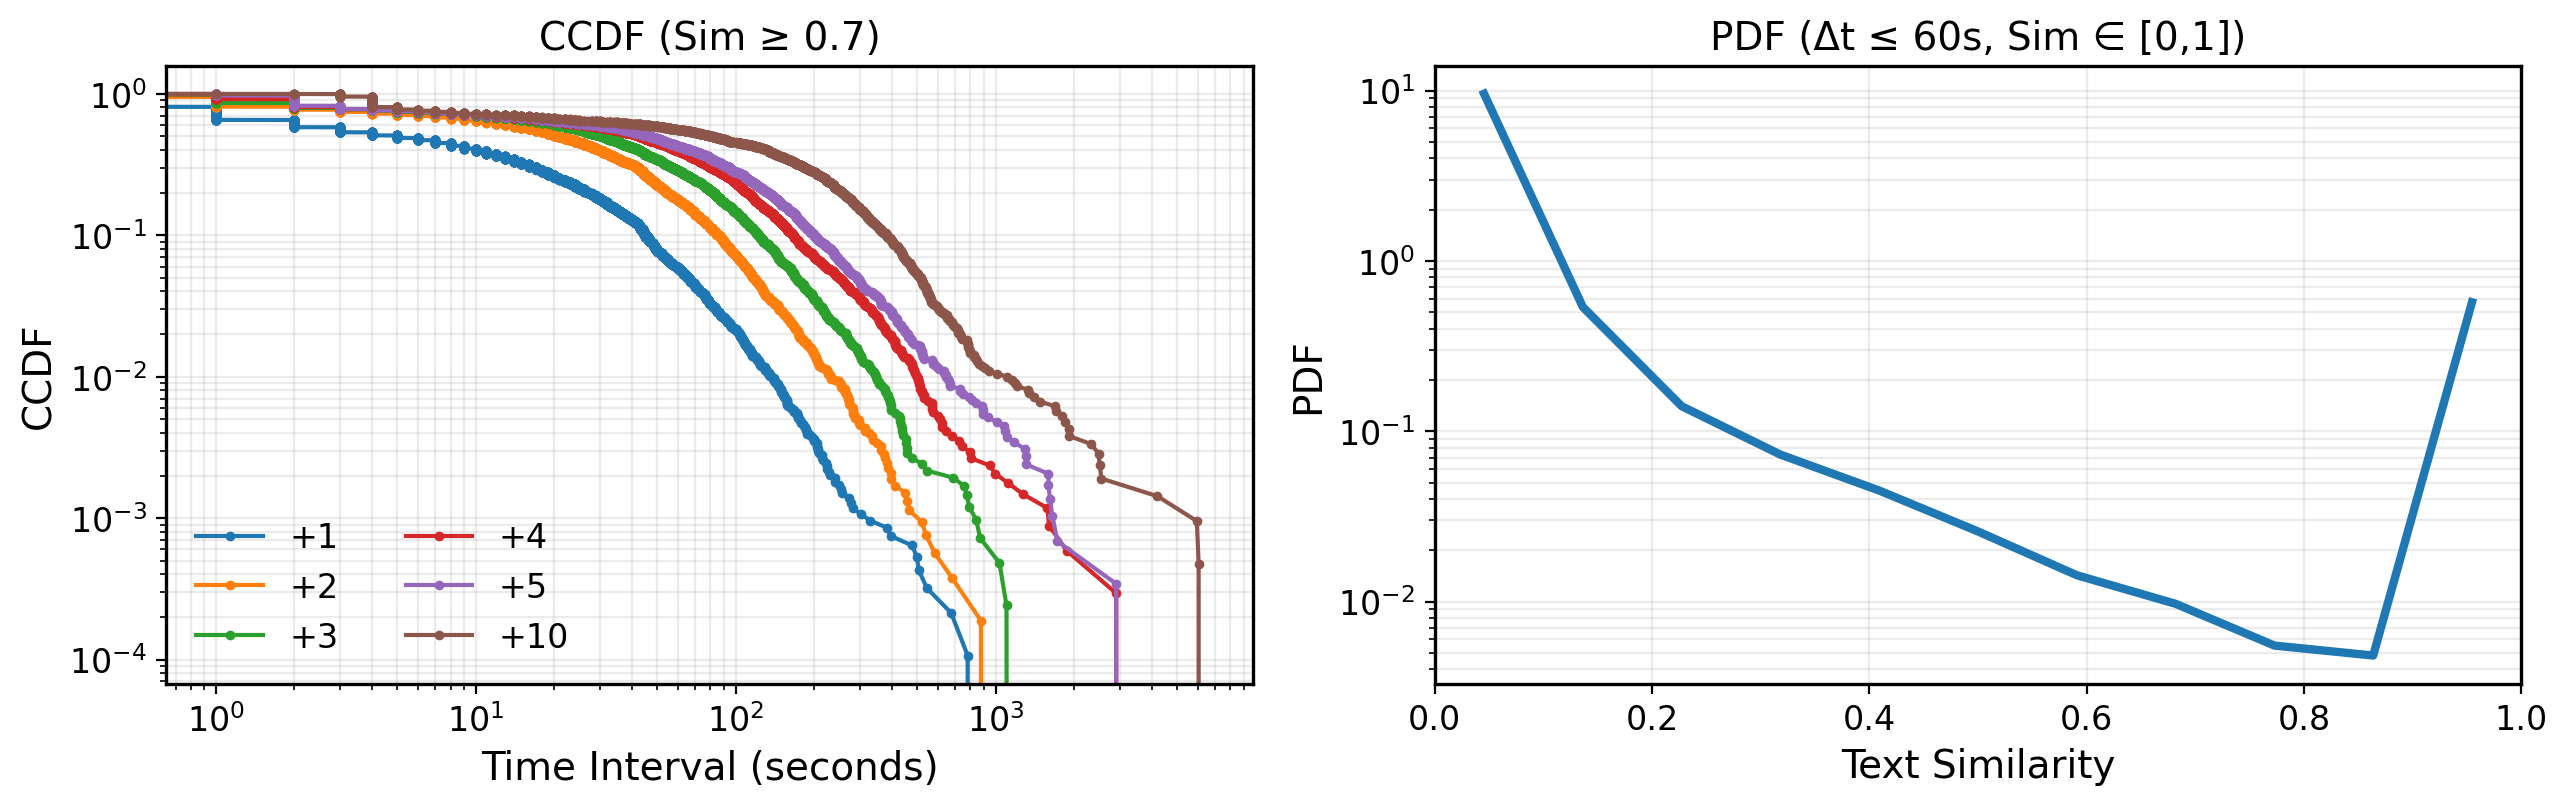

In [9]:
# Parâmetros
TAU_SIM_COLLECT = 0.0     # coleta tudo
TAU_SIM_CCDF    = 0.7     # CCDF exige sim >= 0.7
TAU_TIME_PDF    = 60      # PDF: pares com Δt <= 60s
OFFSETS = [1, 2, 3, 4, 5, 10]

# ------------------------------------------------------------------------------
# 1) Coletar pares i vs i+k
# ------------------------------------------------------------------------------
def coletar_sequential_pairs(times, X, offsets, tau_sim=0.0):
    rows = []
    N = len(times)

    for k in offsets:
        for i in tqdm(range(0, N - k), desc=f"Coletando offset +{k}"):
            j = i + k

            dt = (times[j] - times[i]).total_seconds()
            sim = float(X[i].dot(X[j].T).toarray()[0, 0])

            if sim >= tau_sim:
                rows.append({"offset": k, "delta_t": dt, "similarity": sim})

    return pd.DataFrame(rows)

df_seq = coletar_sequential_pairs(times, X, OFFSETS, tau_sim=TAU_SIM_COLLECT)
print("Pares coletados:", len(df_seq))

# ------------------------------------------------------------------------------
# 2) Plot: (A) CCDF log-log de delta_t por offset +k (sim >= 0.7)
#          (B) PDF de similaridade (Δt <= 60s, sim 0..1)
# ------------------------------------------------------------------------------
def plot_paper_style(df_seq, out_png="Figura_PaperStyle_CCDF_PDF.png"):
    plt.rcParams.update({
        "font.size": 12,
        "axes.linewidth": 1.2,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "legend.fontsize": 12,
    })

    fig, axs = plt.subplots(1, 2, figsize=(13, 4.2), dpi=200)

    # -------------------------
    # (A) CCDF log-log (delta_t) com sim >= 0.7
    # -------------------------
    ax = axs[0]
    df_ccdf = df_seq[df_seq["similarity"] >= TAU_SIM_CCDF]

    for k in sorted(df_seq["offset"].unique()):
        sub = df_ccdf[df_ccdf["offset"] == k]
        if sub.empty:
            continue

        x = np.sort(sub["delta_t"].values)
        y = 1.0 - (np.arange(1, len(x) + 1) / len(x))

        ax.loglog(x, y, marker="o", markersize=2.5, linewidth=1.5, label=f"+{k}")

    ax.set_xlabel("Time Interval (seconds)")
    ax.set_ylabel("CCDF")
    ax.set_title(f"CCDF (Sim ≥ {TAU_SIM_CCDF})")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(ncol=2, frameon=False)

    # -----------------------------------------
    # (B) PDF de similaridade (Δt <= 60s) com sim 0..1
    # -----------------------------------------
    ax = axs[1]
    sub = df_seq[df_seq["delta_t"] <= TAU_TIME_PDF]

    if not sub.empty:
        sims = sub["similarity"].values  # já está 0..1
        bins = np.linspace(0, 1, 12)
        hist, edges = np.histogram(sims, bins=bins, density=True)
        centers = (edges[:-1] + edges[1:]) / 2

        ax.plot(centers, hist, linewidth=3)

        ax.set_yscale("log")
        ax.set_xlabel("Text Similarity")
        ax.set_ylabel("PDF")
        ax.set_title(f"PDF (Δt ≤ {TAU_TIME_PDF}s, Sim ∈ [0,1])")
        ax.grid(True, which="both", alpha=0.25)
    else:
        ax.text(0.5, 0.5, f"Sem pares com Δt ≤ {TAU_TIME_PDF}s",
                ha="center", va="center")
        ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.show()

plot_paper_style(df_seq, out_png="Figura_PaperStyle_CCDF_PDF.png")


### Interpretação

- No período pós-eleitoral, os padrões observados tornam-se ainda mais evidentes. A CCDF mantém o formato de cauda longa, porém com deslocamento das curvas para a direita, indicando que interações altamente similares persistem por intervalos temporais maiores em comparação ao período pré-eleitoral. Esse resultado sugere não apenas continuidade, mas intensificação e prolongamento da atividade coordenada após o evento eleitoral.

- A PDF da similaridade reforça essa interpretação. O regime bimodal permanece, mas o pico de densidade próximo a 1.0 torna-se mais acentuado e definido, indicando maior concentração de mensagens praticamente idênticas. Esse aumento sugere uma padronização discursiva mais forte, compatível com a consolidação de narrativas compartilhadas no período pós-eleitoral.

- Embora o padrão estrutural de coordenação já esteja presente antes da eleição, o período pós-eleitoral apresenta maior volume, persistência temporal e concentração semântica das mensagens altamente similares. Em ambos os períodos, o surgimento consistente de um pico de densidade próximo à similaridade máxima, mesmo sob restrição temporal estrita (≤ 60s), fornece evidência empírica robusta da existência de um regime não aleatório de disseminação de conteúdo.


In [10]:
print(">>> DIAGNÓSTICO DO PICO DE SIMILARIDADE")

# 1. Verificar se a sondagem existe
if 'df_sondagem' not in locals() or df_sondagem.empty:
    print("ERRO: Rode a etapa de Sondagem anterior primeiro!")
else:
    # 2. Filtrar apenas o pico
    df_pico = df_sondagem[df_sondagem['similarity'] > 0.99].copy()
    
    if df_pico.empty:
        print("Curioso... Não há mensagens com similaridade > 0.99 na sondagem.")
        print("Tente baixar o filtro para > 0.95.")
    else:
        # 3. Recuperar o texto original
        print(f"Analisando {len(df_pico)} pares idênticos encontrados...")

        amostra_pico = df_pico.head(100) 
        
        textos_encontrados = []
        
        # Contar repetições no dataset LIMPO diretamente
        # Se tem pico em 1.0, tem texto duplicado no dataframe.
    
        top_duplicatas = df['clean_text'].value_counts().head(20)
        
        print("\nTOP 20 MENSAGENS REPETIDAS NO DATASET LIMPO:")
        print("(Se isso aqui for Spam, o filtro falhou. Se for 'Bom dia', é ruído. Se for política, é ouro.)\n")
        
        for texto, qtd in top_duplicatas.items():
            print(f"[{qtd}x] {texto[:100]}...") # Mostra os primeiros 100 caracteres
            print("-" * 50)

        # Diagnóstico de Tamanho
        print("\nEstatísticas de Tamanho das Duplicatas:")
        top_duplicatas_df = top_duplicatas.reset_index()
        top_duplicatas_df.columns = ['texto', 'contagem']
        top_duplicatas_df['tamanho'] = top_duplicatas_df['texto'].str.len()
        
        curtas = len(top_duplicatas_df[top_duplicatas_df['tamanho'] < 10])
        longas = len(top_duplicatas_df[top_duplicatas_df['tamanho'] > 50])
        
        print(f"Das Top 20 repetidas:")
        print(f"- Curtas (<10 chars, ex: 'ok', 'bom dia'): {curtas}")
        print(f"- Longas (>50 chars, ex: virais/textões): {longas}")

        if curtas > longas:
            print("\n>>> CONCLUSÃO: O pico é causado por MENSAGENS CURTAS (Ruído).")
        else:
            print("\n>>> CONCLUSÃO: O pico é causado por CONTEÚDO VIRAL REAL.")

>>> DIAGNÓSTICO DO PICO DE SIMILARIDADE
Analisando 14356 pares idênticos encontrados...

TOP 20 MENSAGENS REPETIDAS NO DATASET LIMPO:
(Se isso aqui for Spam, o filtro falhou. Se for 'Bom dia', é ruído. Se for política, é ouro.)

[732x] acesse link entrar grupo whatsapp chatwhatsappcom...
--------------------------------------------------
[531x] toque ver backhandindexpointingdownmediumlightskintonebackhandindexpointingdownmediumlightskintoneba...
--------------------------------------------------
[435x] vai passando rola lula compartilhe chegar cu bolsonaro star13 13 13 13 13 13 13 13 13 13 13 13 13 13...
--------------------------------------------------
[193x] vamos seguir instagram exército brasileiro mudarmos 21 milhões minimo 20 milhões acredito clara dese...
--------------------------------------------------
[159x] leia matéria completa rightarrowcurvingdowninstagramcom...
--------------------------------------------------
[155x] bookmarkleia matéria completa instagramcom...
----

### Construção da rede

In [11]:
# Parâmetros definidos pela análise dos gráficos:
TIME_WINDOW = 60        # 60 segundos (Kansaon et al.)
MIN_SIMILARITY = 0.70   # Similaridade >= 0.7 (Pacheco)
MIN_WEIGHT = 2          # Mínimo de interações para considerar coordenação (Filtro de Ruído)
                        # Nota: Kansaon usou 5

print(f">>> Iniciando construção da rede de coordenação...")
print(f"Janela: {TIME_WINDOW}s | Similaridade > {MIN_SIMILARITY} | Peso Mínimo: {MIN_WEIGHT}")

# Estruturas para guardar as arestas
edges = {} # Dicionário {(user_a, user_b): peso}
window_td = pd.Timedelta(seconds=TIME_WINDOW)

for i in tqdm(range(N), desc="Processando janelas"):
    
    # 1. Definir limites da janela deslizante para a mensagem i
    t_start = times[i]
    t_end = t_start + window_td
    
    # 2. Busca Binária (Otimização Extrema)
    # Encontra onde termina a janela de 60s na lista de tempos ordenada
    slice_end = bisect_right(times, t_end, lo=i+1)
    
    # Se não tem ninguém na janela, pula para a próxima mensagem
    if slice_end <= i + 1:
        continue
        
    # 3. Pegar o bloco de mensagens vizinhas (candidatos a coordenação)
    current_vec = X[i]
    candidate_block = X[i+1 : slice_end]
    
    # 4. Cálculo de Similaridade em Lote (Matricial)
    # Calcula o cosseno de [i] contra todos os vizinhos da janela de uma vez só
    similarities = candidate_block.dot(current_vec.T).toarray().flatten()
    
    # 5. Filtragem e Criação de Arestas
    # Pega apenas os índices onde a similaridade superou o corte de 0.7
    match_indices = np.where(similarities >= MIN_SIMILARITY)[0]
    
    if len(match_indices) > 0:
        user_i = users[i] # Quem mandou a mensagem original
        
        # Ajustar índices locais para globais
        global_indices = (i + 1) + match_indices
        
        for g_idx in global_indices:
            user_j = users[g_idx] # Quem mandou a mensagem coordenada
            
            # Regra: Não criar aresta consigo mesmo (self-loop)
            if user_i == user_j:
                continue
            
            # Ordenar IDs para garantir que a aresta (A, B) seja igual a (B, A)
            # Isso cria uma rede "Não Direcionada" (Undirected), padrão para coordenação
            u1, u2 = sorted((str(user_i), str(user_j)))
            key = (u1, u2)
            
            # Contabilizar peso (força da coordenação)
            edges[key] = edges.get(key, 0) + 1

# ==============================================================================
# 4. EXPORTAÇÃO DA REDE
# ==============================================================================
print(f"\n>>> Processamento concluído!")
print(f"Total de pares brutos encontrados: {len(edges)}")

# Criar DataFrame de arestas
df_edges = pd.DataFrame(
    [(u1, u2, w) for (u1, u2), w in edges.items()],
    columns=['Source', 'Target', 'Weight']
)

# Filtro de Peso
# Remover pares que coincidiram apenas 1 vez (pode ser acaso) se MIN_WEIGHT > 1
df_edges_filtered = df_edges[df_edges['Weight'] >= MIN_WEIGHT].copy()

print(f"Arestas finais após filtro de peso (Weight >= {MIN_WEIGHT}): {len(df_edges_filtered)}")

# Salvar arquivo pronto para Gephi / NetworkX
filename_out = "P2_rede_coordenacao_final_07_60s.csv"
df_edges_filtered.to_csv(filename_out, index=False)
print(f"Arquivo de rede salvo com sucesso: {filename_out}")

# Estatísticas da rede gerada
n_nodes = pd.concat([df_edges_filtered['Source'], df_edges_filtered['Target']]).nunique()
print(f"Número de Usuários Coordenados (Nós): {n_nodes}")

>>> Iniciando construção da rede de coordenação...
Janela: 60s | Similaridade > 0.7 | Peso Mínimo: 2


Processando janelas:   0%|          | 0/150074 [00:00<?, ?it/s]


>>> Processamento concluído!
Total de pares brutos encontrados: 860
Arestas finais após filtro de peso (Weight >= 2): 176
Arquivo de rede salvo com sucesso: P2_rede_coordenacao_final_07_60s.csv
Número de Usuários Coordenados (Nós): 237


In [12]:
# ------------------------------------------------------------
# 1) Configuração Inicial da Rede
# ------------------------------------------------------------
net = Network(
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="#222",
    notebook=False,
    directed=False
)

# 2) Ajustes de física
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=120, spring_strength=0.02, damping=0.25)
net.toggle_physics(True)
net.show_buttons(filter_=["physics"]) 

# ------------------------------------------------------------
# 3) Loop para Adicionar Nós e Arestas
# ------------------------------------------------------------
if 'df_edges_filtered' in locals():
    print("Iniciando a construção da rede...")
    
    for index, row in df_edges_filtered.iterrows():
        u = row['Source'] 
        v = row['Target']
        w = int(row['Weight'])
        
        # Adiciona nós (se não existirem)
        try:
            net.get_node(u)
        except KeyError:
            net.add_node(u, label=str(u), title=f"Usuário: {u}")

        try:
            net.get_node(v)
        except KeyError:
            net.add_node(v, label=str(v), title=f"Usuário: {v}")

        # Adiciona aresta
        net.add_edge(u, v, value=w, title=f"Peso: {w}")

    print(f"Rede criada com sucesso: {len(net.nodes)} nós e {len(net.edges)} arestas.")

else:
    print("ERRO: O DataFrame 'df_edges_filtered' não foi encontrado.")

# ------------------------------------------------------------
# 4) Salvar e Abrir 
# ------------------------------------------------------------
filename_html = "2_rede_coordenacao_interativa.html"

try:
    # 1. Gera e Salva o Arquivo
    html_content = net.generate_html()
    
    with open(filename_html, "w", encoding="utf-8") as f:
        f.write(html_content)
    
    print(f"Arquivo salvo com sucesso: {filename_html}")

    # 2. Tenta abrir automaticamente
    try:
        os.startfile(filename_html)
    except AttributeError:
        # startfile só existe no Windows. Se for Linux/Mac, apenas ignora.
        print("Abertura automática ignorada (SO não compatível). Abra o arquivo manualmente.")
    except Exception as e:
        print(f"Não foi possível abrir automaticamente: {e}")

except Exception as e:
    print(f"Erro ao salvar em UTF-8: {e}")
    
    # Plano B: Salvar ignorando erros de caracteres
    print("Tentando salvar versão alternativa (cp1252)...")
    try:
        with open("2_rede_sem_emojis.html", "w", encoding="cp1252", errors="ignore") as f:
            f.write(net.generate_html())
        print("Salvo como '2_rede_sem_emojis.html'.")
    except Exception as e2:
        print(f" Falha crítica ao salvar: {e2}")

Iniciando a construção da rede...
Rede criada com sucesso: 237 nós e 176 arestas.
Arquivo salvo com sucesso: 2_rede_coordenacao_interativa.html


### Interpretação

- Entre o período pré e pós, observa-se uma transição de uma coordenação esparsa e episódica para uma estrutura mais ampla, persistente e discursivamente alinhada, caracterizada por aumento do número de usuários coordenados, maior densidade de interações repetidas e maior recorrência de mensagens altamente similares em janelas temporais curtas.

- Ao comparar os conjuntos de usuários envolvidos em interações coordenadas (considerando os nós como a união entre Source e Target), observamos baixa continuidade entre os períodos. O PRE2022 contém 170 usuários coordenados e o POS2022 contém 237, com apenas 36 usuários em comum. Isso corresponde a 21,2% dos usuários do PRE e 15,2% do POS. O índice de Jaccard entre os conjuntos foi 0,097, indicando que menos de 10% do conjunto total de usuários coordenados aparece em ambos os períodos. Esses resultados sugerem uma reconfiguração substancial do elenco de atores coordenados entre o pré e o pós-eleição, com expansão no número de participantes e preservação de um subconjunto pequeno, possivelmente mais persistente.

,nodes_n,edges_m,density,avg_degree,avg_strength_weighted_degree,num_connected_components,largest_component_size,num_isolates,edge_weight_min,edge_weight_q1,edge_weight_median,edge_weight_mean,edge_weight_q3,edge_weight_max,pct_edges_weight_eq_2
0,237,176,0.006293,1.485,17.553,71,59,0,2,2.00,2.00,11.82,4.00,511,57.39


,Source,Target,Weight
0,4ea1b3ee637da811b7d2d0df32db21f9,ef496106907ece8b169c6219e5470b2c,511
1,f9a3713e47528edc24d8339e3722aee5,fac2d68f7a1e0334c7e57887818345ba,174
2,5bc42f808afaffc8c05bfceab9500ea0,fac2d68f7a1e0334c7e57887818345ba,168
3,b66e161a06f8a08eafc03104846794df,ef496106907ece8b169c6219e5470b2c,167
4,077abe419909f420944565f20eac1de3,244cf1848fe9db1f1ac33ff46ee1354b,114
5,4ea1b3ee637da811b7d2d0df32db21f9,b66e161a06f8a08eafc03104846794df,94
6,3bc964535b8e6bae52c2d9b8fcc73024,ef496106907ece8b169c6219e5470b2c,84
7,5bc42f808afaffc8c05bfceab9500ea0,f9a3713e47528edc24d8339e3722aee5,67
8,a27ce2e80d07c12d6b7980bba16a06b3,b6242381059f781a69bc6d7b4803c25b,60
9,3bc964535b8e6bae52c2d9b8fcc73024,4ea1b3ee637da811b7d2d0df32db21f9,47


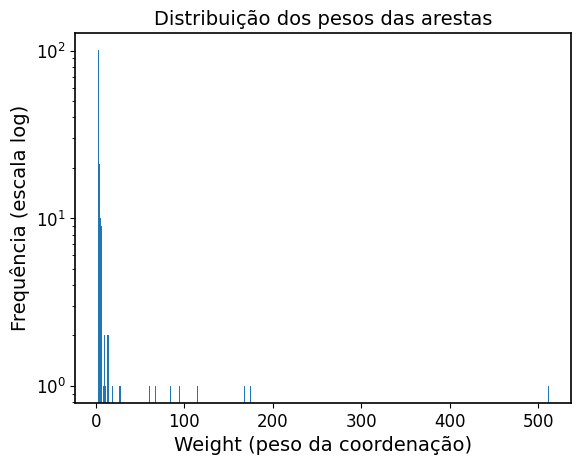

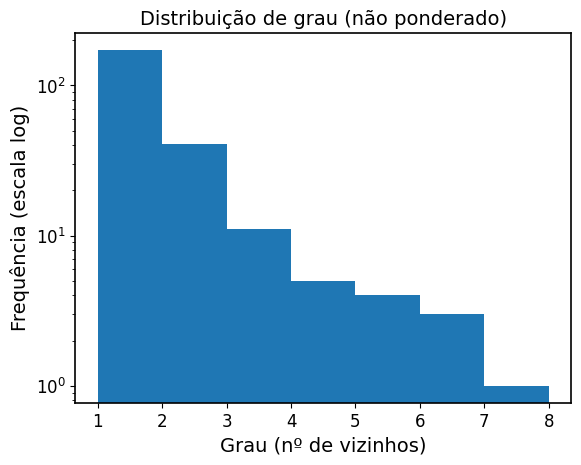

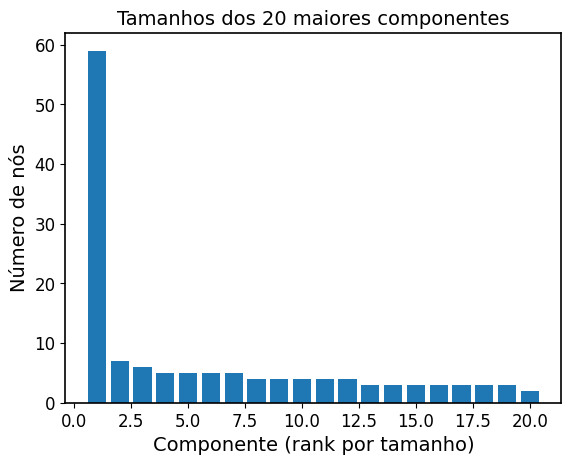

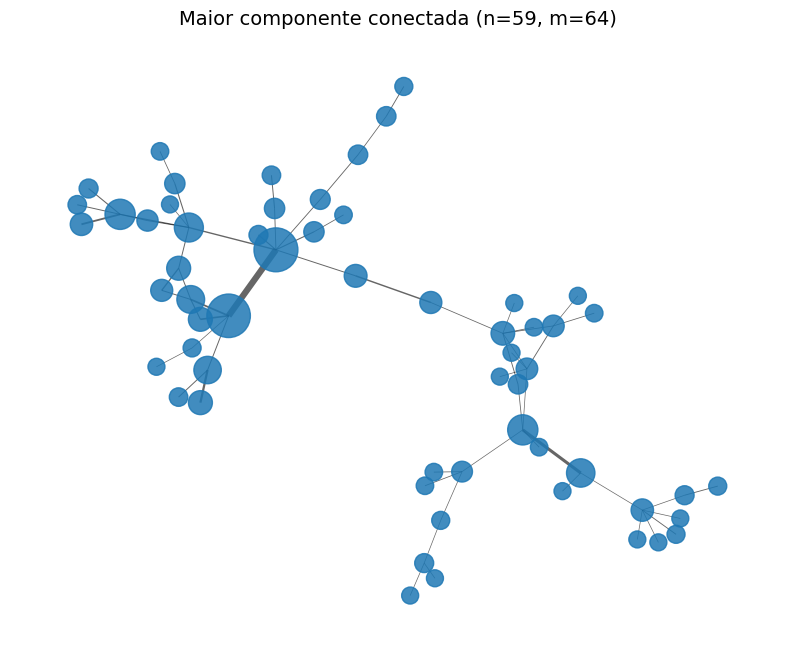

In [13]:
# =========================
# 0) Leitura do dataset
# =========================
PATH = "P2_rede_coordenacao_final_07_60s.csv"
# Se precisar:
# PATH = "/mnt/data/rede_coordenacao_final_07_60s.csv"

df = pd.read_csv(PATH)

required = {"Source", "Target", "Weight"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Colunas faltando no CSV: {missing}. Encontrei: {list(df.columns)}")

df["Source"] = df["Source"].astype(str)
df["Target"] = df["Target"].astype(str)
df["Weight"] = pd.to_numeric(df["Weight"], errors="coerce").fillna(0).astype(int)

# remove pesos inválidos/zero
df = df[df["Weight"] > 0].copy()

# =========================
# 1) Construção do grafo
# =========================
G = nx.from_pandas_edgelist(df, "Source", "Target", edge_attr="Weight", create_using=nx.Graph())

n = G.number_of_nodes()
m = G.number_of_edges()
density = nx.density(G) if n > 1 else 0.0
avg_degree = (2 * m / n) if n > 0 else 0.0

strength = dict(G.degree(weight="Weight"))
avg_strength = (sum(strength.values()) / n) if n > 0 else 0.0

components = list(nx.connected_components(G))
num_components = len(components)
comp_sizes = sorted([len(c) for c in components], reverse=True) if components else []
largest_comp_size = comp_sizes[0] if comp_sizes else 0
isolates = list(nx.isolates(G))

weights = df["Weight"].to_numpy()
w = pd.Series(weights)

# =========================
# 2) Tabela-resumo (paper)
# =========================
summary = {
    "nodes_n": n,
    "edges_m": m,
    "density": density,
    "avg_degree": avg_degree,
    "avg_strength_weighted_degree": avg_strength,
    "num_connected_components": num_components,
    "largest_component_size": largest_comp_size,
    "num_isolates": len(isolates),
    "edge_weight_min": int(w.min()) if len(w) else 0,
    "edge_weight_q1": float(w.quantile(0.25)) if len(w) else 0.0,
    "edge_weight_median": float(w.median()) if len(w) else 0.0,
    "edge_weight_mean": float(w.mean()) if len(w) else 0.0,
    "edge_weight_q3": float(w.quantile(0.75)) if len(w) else 0.0,
    "edge_weight_max": int(w.max()) if len(w) else 0,
    "pct_edges_weight_eq_2": float(100 * (weights == 2).mean()) if len(weights) else 0.0,
}

summary_df = pd.DataFrame([summary])

# formatação amigável
display(summary_df.style.format({
    "density": "{:.6f}",
    "avg_degree": "{:.3f}",
    "avg_strength_weighted_degree": "{:.3f}",
    "edge_weight_q1": "{:.2f}",
    "edge_weight_median": "{:.2f}",
    "edge_weight_mean": "{:.2f}",
    "edge_weight_q3": "{:.2f}",
    "pct_edges_weight_eq_2": "{:.2f}",
}))

# Top-10 arestas por peso (tabela auxiliar útil)
top_edges = df.sort_values("Weight", ascending=False).head(10).reset_index(drop=True)
display(top_edges)

# =========================
# 3) Visualizações
# =========================

# 3.1) Distribuição dos pesos
plt.figure()
bins = np.arange(weights.min(), weights.max() + 2) if len(weights) else [0, 1]
plt.hist(weights, bins=bins)
plt.yscale("log")
plt.xlabel("Weight (peso da coordenação)")
plt.ylabel("Frequência (escala log)")
plt.title("Distribuição dos pesos das arestas")
plt.show()

# 3.2) Distribuição de grau (não ponderado)
deg = np.array([d for _, d in G.degree()]) if n else np.array([])
plt.figure()
bins = np.arange(deg.min(), deg.max() + 2) if len(deg) else [0, 1]
plt.hist(deg, bins=bins)
plt.yscale("log")
plt.xlabel("Grau (nº de vizinhos)")
plt.ylabel("Frequência (escala log)")
plt.title("Distribuição de grau (não ponderado)")
plt.show()

# 3.3) Componentes conectados (top 20)
top_k = 20
top_sizes = comp_sizes[:top_k]
plt.figure()
plt.bar(range(1, len(top_sizes) + 1), top_sizes)
plt.xlabel("Componente (rank por tamanho)")
plt.ylabel("Número de nós")
plt.title(f"Tamanhos dos {min(top_k, len(comp_sizes))} maiores componentes")
plt.show()

# 3.4) Maior componente (layout)
if largest_comp_size >= 2:
    largest_nodes = max(components, key=len)
    H = G.subgraph(largest_nodes).copy()

    pos = nx.spring_layout(H, seed=42)

    H_strength = dict(H.degree(weight="Weight"))
    vals = np.array(list(H_strength.values()), dtype=float)
    sizes = 300 if len(vals) == 0 else 150 + 850 * (vals - vals.min()) / (vals.max() - vals.min() + 1e-9)

    eweights = np.array([H[u][v]["Weight"] for u, v in H.edges()], dtype=float)
    widths = 1.0 if len(eweights) == 0 else 0.5 + 4.0 * (eweights - eweights.min()) / (eweights.max() - eweights.min() + 1e-9)

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_edges(H, pos, width=widths, alpha=0.6)
    nx.draw_networkx_nodes(H, pos, node_size=sizes, alpha=0.85)
    plt.title(f"Maior componente conectada (n={H.number_of_nodes()}, m={H.number_of_edges()})")
    plt.axis("off")
    plt.show()
else:
    print("Maior componente muito pequena para visualização.")


### Interpretação

Comparando os períodos, a rede pós-eleitoral apresenta expansão em número de usuários (170→237) e arestas (129→176), porém com aumento da fragmentação (componentes 47→71) e redução de densidade (0,00898→0,00629), sugerindo descentralização da coordenação em múltiplos grupos desconectados. Apesar disso, observa-se intensificação substancial das interações: o grau ponderado médio dobra (8,48→17,55), o peso médio das arestas aumenta (5,59→11,82) e a fração de arestas mínimas (peso=2) diminui (67,44%→57,39%), indicando coordenação mais robusta. Adicionalmente, alguns vínculos persistem e se intensificam entre os períodos — por exemplo, a aresta de maior peso (4ea1b3…–ef4961…) cresce de 247 para 511 — evidenciando continuidade de um núcleo coordenado e simultânea emergência de novos blocos altamente ativos no pós-eleitoral.

A sobreposição entre períodos é pequena (36 usuários), porém esses usuários persistentes estão desproporcionalmente concentrados no núcleo estrutural (k-core máximo), especialmente no período pré-eleitoral (≈11×). Isso sugere persistência de atores centrais e reconfiguração periférica entre os períodos.



In [14]:
# ==============================================================================
# 5. DETECÇÃO DE COMUNIDADES E ANÁLISE DE REDE
# ==============================================================================
print(">>> Iniciando análise de comunidades (Algoritmo Louvain)...")

# 1. Carregar a rede salva
filename_in = "P2_rede_coordenacao_final_07_60s.csv"
df_edges = pd.read_csv(filename_in)

# 2. Construir o Grafo
G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target', edge_attr='Weight')

# 3. Aplicar Algoritmo Louvain (Detectar os "Times")
# Isso adiciona o atributo 'community' a cada nó
try:
    partition = community_louvain.best_partition(G, weight='Weight')
except ImportError:
    # Fallback se a lib não estiver instalada (usa algoritmo nativo do NetworkX)
    print("Aviso: python-louvain não encontrado. Usando greedy_modularity do NetworkX.")
    from networkx.algorithms.community import greedy_modularity_communities
    communities = greedy_modularity_communities(G, weight='Weight')
    partition = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            partition[node] = idx

# 4. Calcular Métricas de Importância (Grau/Degree)
degrees = dict(G.degree())

# 5. Exportar Tabela de Nós (CRUCIAL para a próxima etapa de análise de texto)
# Vamos salvar quem pertence a qual comunidade para depois ler o que eles falaram
df_nodes = pd.DataFrame({
    'user_id': list(partition.keys()),
    'community_id': list(partition.values()),
    'degree': [degrees[n] for n in partition.keys()]
})

# Salvar métricas dos nós
df_nodes.sort_values(by='degree', ascending=False, inplace=True)
df_nodes.to_csv("nos_e_comunidades.csv", index=False)
print(f"Tabela de nós salva: 'nos_e_comunidades.csv' ({len(df_nodes)} usuários).")

# Mostrar resumo das maiores comunidades
top_comunidades = df_nodes['community_id'].value_counts().head(5)
print("\nTop 5 Maiores Comunidades de Coordenação:")
print(top_comunidades)

filename_html = "rede_final_louvain2.html"

try:
    # 1. Gera o código HTML internamente sem salvar no disco ainda
    html_content = net.generate_html()
    
    # 2. Salva manualmente forçando UTF-8 (Suporte a Emojis)
    with open(filename_html, "w", encoding="utf-8") as f:
        f.write(html_content)
            
    # Tenta abrir automaticamente (apenas Windows)
    try:
        os.startfile(filename_html)
    except:
        pass

except Exception as e:
    print(f"Erro ao salvar: {e}")

>>> Iniciando análise de comunidades (Algoritmo Louvain)...
Tabela de nós salva: 'nos_e_comunidades.csv' (237 usuários).

Top 5 Maiores Comunidades de Coordenação:
community_id
64    28
25    28
41     7
2      6
29     5
Name: count, dtype: int64


,threshold,nodes_n,edges_m,density,avg_degree,avg_strength,num_components,largest_component,edge_weight_min,edge_weight_median,edge_weight_mean,edge_weight_max,pct_edges_weight_eq_2
0,2,237,176,0.006293,1.485,17.553,71,59,2,2.00,11.82,511,57.39
1,5,46,41,0.039614,1.783,76.652,12,20,5,9.00,43.00,511,0.00
2,10,26,19,0.058462,1.462,125.615,10,4,10,47.00,85.95,511,0.00
3,20,15,12,0.114286,1.600,205.200,6,4,26,89.00,128.25,511,0.00


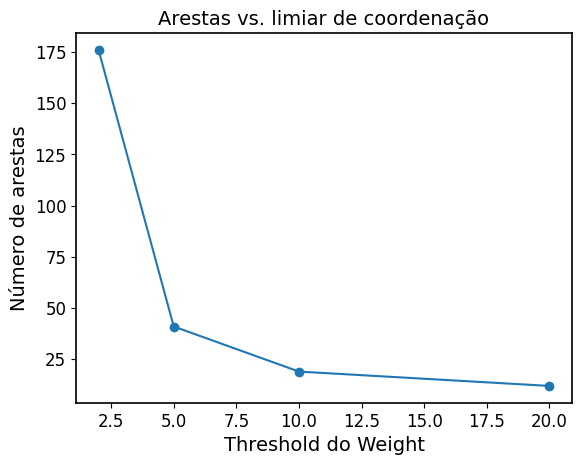

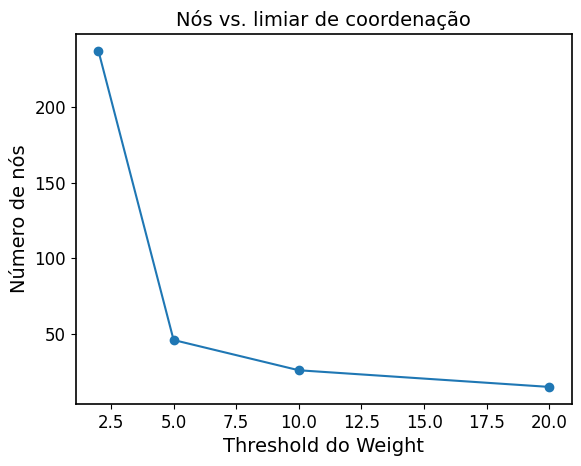

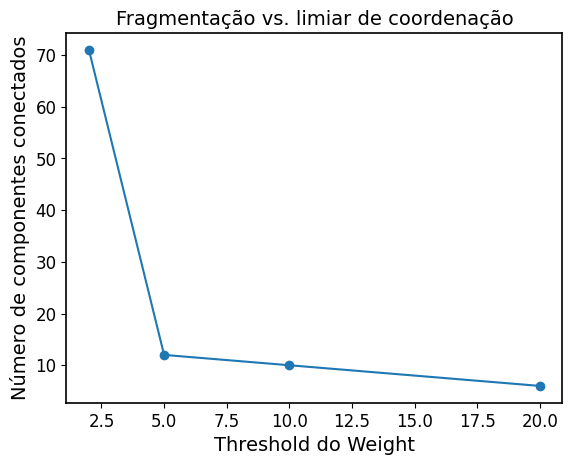

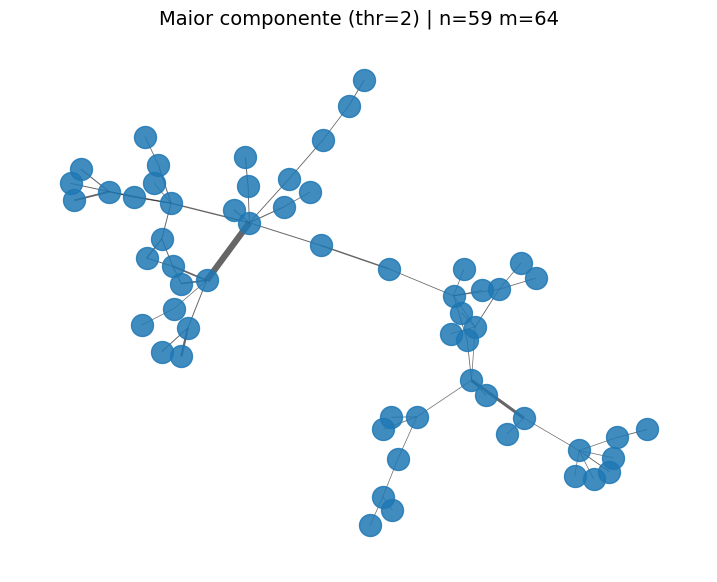

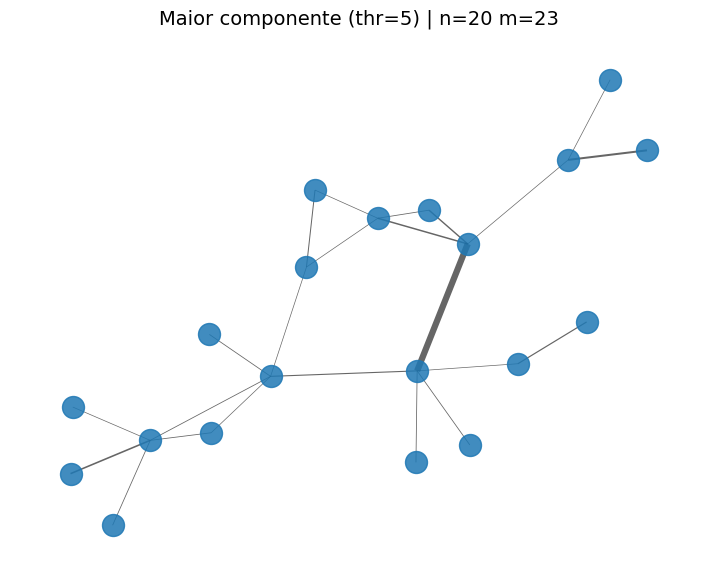

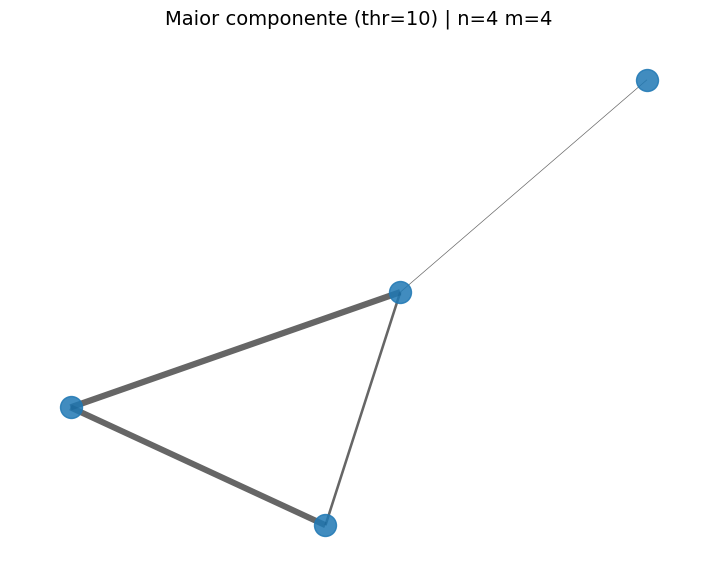

In [15]:
PATH = "P2_rede_coordenacao_final_07_60s.csv"
df = pd.read_csv(PATH)

df["Source"] = df["Source"].astype(str)
df["Target"] = df["Target"].astype(str)
df["Weight"] = pd.to_numeric(df["Weight"], errors="coerce").fillna(0).astype(int)
df = df[df["Weight"] > 0].copy()

thresholds = [2, 5, 10, 20]

def build_graph(df_sub):
    return nx.from_pandas_edgelist(df_sub, "Source", "Target", edge_attr="Weight", create_using=nx.Graph())

def summarize_graph(G, df_sub, thr):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G) if n > 1 else 0.0
    avg_degree = (2*m/n) if n > 0 else 0.0
    strength = dict(G.degree(weight="Weight"))
    avg_strength = (sum(strength.values())/n) if n > 0 else 0.0
    
    comps = list(nx.connected_components(G))
    num_comps = len(comps)
    largest = max((len(c) for c in comps), default=0)
    
    w = df_sub["Weight"].to_numpy()
    pct_w2 = 100 * (w == 2).mean() if len(w) else 0.0
    
    return {
        "threshold": thr,
        "nodes_n": n,
        "edges_m": m,
        "density": density,
        "avg_degree": avg_degree,
        "avg_strength": avg_strength,
        "num_components": num_comps,
        "largest_component": largest,
        "edge_weight_min": int(w.min()) if len(w) else 0,
        "edge_weight_median": float(np.median(w)) if len(w) else 0.0,
        "edge_weight_mean": float(np.mean(w)) if len(w) else 0.0,
        "edge_weight_max": int(w.max()) if len(w) else 0,
        "pct_edges_weight_eq_2": pct_w2
    }

rows = []
graphs = {}

for thr in thresholds:
    df_sub = df[df["Weight"] >= thr].copy()
    G = build_graph(df_sub)
    graphs[thr] = (G, df_sub)
    rows.append(summarize_graph(G, df_sub, thr))

summary_layers = pd.DataFrame(rows)

display(summary_layers.style.format({
    "density": "{:.6f}",
    "avg_degree": "{:.3f}",
    "avg_strength": "{:.3f}",
    "edge_weight_median": "{:.2f}",
    "edge_weight_mean": "{:.2f}",
    "pct_edges_weight_eq_2": "{:.2f}",
}))

# ---- Figura: como a rede "encolhe" ao aumentar o limiar ----
plt.figure()
plt.plot(summary_layers["threshold"], summary_layers["edges_m"], marker="o")
plt.xlabel("Threshold do Weight")
plt.ylabel("Número de arestas")
plt.title("Arestas vs. limiar de coordenação")
plt.show()

plt.figure()
plt.plot(summary_layers["threshold"], summary_layers["nodes_n"], marker="o")
plt.xlabel("Threshold do Weight")
plt.ylabel("Número de nós")
plt.title("Nós vs. limiar de coordenação")
plt.show()

plt.figure()
plt.plot(summary_layers["threshold"], summary_layers["num_components"], marker="o")
plt.xlabel("Threshold do Weight")
plt.ylabel("Número de componentes conectados")
plt.title("Fragmentação vs. limiar de coordenação")
plt.show()

# ---- Desenho do maior componente para cada camada (opcional: roda 1 por vez) ----
for thr in [2, 5, 10]:
    G, df_sub = graphs[thr]
    comps = list(nx.connected_components(G))
    if not comps:
        print(f"[thr={thr}] grafo vazio.")
        continue
    largest_nodes = max(comps, key=len)
    H = G.subgraph(largest_nodes).copy()
    if H.number_of_nodes() < 2:
        print(f"[thr={thr}] maior componente muito pequena.")
        continue

    pos = nx.spring_layout(H, seed=42)
    eweights = np.array([H[u][v]["Weight"] for u, v in H.edges()], dtype=float)
    widths = 0.5 + 4.0 * (eweights - eweights.min()) / (eweights.max() - eweights.min() + 1e-9)

    plt.figure(figsize=(9, 7))
    nx.draw_networkx_edges(H, pos, width=widths, alpha=0.6)
    nx.draw_networkx_nodes(H, pos, node_size=250, alpha=0.85)
    plt.title(f"Maior componente (thr={thr}) | n={H.number_of_nodes()} m={H.number_of_edges()}")
    plt.axis("off")
    plt.show()


### Interpretação


In [16]:
# ------------------------------------------------------------
# Helpers de escala
# ------------------------------------------------------------
def scale_node_size(deg, min_size=8, max_size=45):
    # deg -> tamanho com compressão log (evita "um nó gigante")
    v = np.log1p(deg)
    # normaliza depois (vai ser reescalado no bloco abaixo)
    return v

def scale_edge_width(w, min_w=1.0, max_w=8.0):
    # compressão leve pra weights altos não virarem "cabos"
    return np.log1p(w)

def get_color_hex(comm_id, n_colors=20):
    # Matplotlib 3.7+: usar colormaps sem get_cmap (evita warning)
    cmap = plt.colormaps.get_cmap("tab20")
    return mcolors.to_hex(cmap(comm_id % n_colors))

# ------------------------------------------------------------
# 1) Escolha do subgrafo para visualização
# ------------------------------------------------------------
# Mantém componentes com pelo menos 3 nós 
components = [c for c in nx.connected_components(G) if len(c) >= 2]
G_viz = G.subgraph(set().union(*components)).copy() if components else G.copy()

MIN_WEIGHT_VIZ = 2
edges_to_keep = [(u, v) for u, v, d in G_viz.edges(data=True) if d.get("Weight", 1) >= MIN_WEIGHT_VIZ]
G_viz = G_viz.edge_subgraph(edges_to_keep).copy()

print("Nós (viz):", G_viz.number_of_nodes(), "Arestas (viz):", G_viz.number_of_edges())

# ------------------------------------------------------------
# 2) Preparar escalas globais (nó e aresta)
# ------------------------------------------------------------
deg_map = dict(G_viz.degree())  # degree no subgrafo visual
deg_values = np.array([deg_map[n] for n in G_viz.nodes()], dtype=float)

# escala nó
node_raw = np.array([scale_node_size(d) for d in deg_values])
if len(node_raw) > 0:
    node_min, node_max = node_raw.min(), node_raw.max()
else:
    node_min, node_max = 0, 1

def rescale(x, a, b, new_a, new_b):
    if b - a == 0:
        return (new_a + new_b) / 2
    return new_a + (x - a) * (new_b - new_a) / (b - a)

node_sizes = {n: rescale(scale_node_size(deg_map[n]), node_min, node_max, 10, 50) for n in G_viz.nodes()}

# escala aresta
w_values = np.array([d.get("Weight", 1) for _, _, d in G_viz.edges(data=True)], dtype=float)
w_raw = np.array([scale_edge_width(w) for w in w_values]) if len(w_values) else np.array([1.0])
w_min, w_max = w_raw.min(), w_raw.max()

def edge_width(w):
    return rescale(scale_edge_width(w), w_min, w_max, 1.0, 10.0)

# ------------------------------------------------------------
# 3) Criar PyVis com layout bom pra comunidades
# ------------------------------------------------------------
net = Network(
    notebook=True,
    height="800px",
    width="100%",
    bgcolor="white",        
    font_color="black",
    directed=False,
    cdn_resources="in_line"   
)

# Configurações do vis.js (substitui show_buttons, evita bug)
# physics: ForceAtlas2Based costuma separar clusters melhor
net.set_options(r"""
var options = {
  "nodes": {
    "borderWidth": 1,
    "shadow": true,
    "font": { "size": 14 }
  },
  "edges": {
    "smooth": { "type": "dynamic" },
    "shadow": false,
    "color": { "inherit": true }
  },
  "physics": {
    "enabled": true,
    "forceAtlas2Based": {
      "gravitationalConstant": -60,
      "centralGravity": 0.02,
      "springLength": 140,
      "springConstant": 0.05,
      "damping": 0.6,
      "avoidOverlap": 1.0
    },
    "minVelocity": 0.5,
    "solver": "forceAtlas2Based"
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 120,
    "navigationButtons": true,
    "keyboard": true
  }
}
""")

# ------------------------------------------------------------
# 4) Adicionar nós (cor por comunidade + tamanho por degree)
# ------------------------------------------------------------
TOP_K_LABELS = 20
top_nodes = sorted(G_viz.nodes(), key=lambda n: deg_map[n], reverse=True)[:TOP_K_LABELS]
top_set = set(top_nodes)

for node in G_viz.nodes():
    comm_id = partition.get(node, -1)
    deg = deg_map.get(node, 0)

    label = str(node) if node in top_set else ""  # só os mais importantes aparecem

    net.add_node(
        node,
        label=label,
        title=(
            f"<b>User:</b> {node}<br>"
            f"<b>Community:</b> {comm_id}<br>"
            f"<b>Degree:</b> {deg}"
        ),
        size=float(node_sizes[node]),
        color=get_color_hex(comm_id),
        group=int(comm_id) if comm_id is not None else 0
    )

# ------------------------------------------------------------
# 5) Adicionar arestas (espessura por Weight + tooltip do peso)
# ------------------------------------------------------------
for u, v, data in G_viz.edges(data=True):
    w = int(data.get("Weight", 1))
    net.add_edge(
        u, v,
        value=w,                 # usado internamente pelo PyVis
        width=float(edge_width(w)),  # espessura visível
        title=f"<b>Weight:</b> {w}"
    )

# ------------------------------------------------------------
# 6) Salvar HTML com UTF-8 (resolve UnicodeEncodeError no Windows)
# ------------------------------------------------------------
filename_html = "rede_final_louvain_comunidades.html"
html_content = net.generate_html()

with open(filename_html, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"HTML salvo (UTF-8): {filename_html}")

# Abrir automaticamente (Windows)
try:
    os.startfile(filename_html)
except:
    pass

Nós (viz): 26 Arestas (viz): 19
HTML salvo (UTF-8): rede_final_louvain_comunidades.html


### Comunidades Louvain

Aplicando detecção de comunidades (Louvain) sobre a rede de coordenação construída com weight ≥ 2, foram identificadas 72 comunidades em um total de 237 nós, indicando uma estrutura fortemente fragmentada. A distribuição dos tamanhos é altamente assimétrica: a maior parte das comunidades é pequena, com predominância de díades (comunidades com 2 nós), enquanto poucas comunidades concentram parcela substancial dos participantes. Em particular, as duas maiores comunidades reúnem cerca de um quarto dos nós, sugerindo um padrão de “núcleo vs periferia”: alguns módulos maiores relativamente mais coesos coexistem com uma periferia extensa composta por agrupamentos mínimos.



>>> Calculando métricas topológicas da rede...
Calculando Degree Centrality...
Calculando Betweenness Centrality...
Calculando Eigenvector Centrality...

TOP  POR MÉTRICA

--- A. Maior Influência (Eigenvector) ---
Estar conectado aos 'chefes'. Quem está no núcleo duro da coordenação.
                              user_id  Comunidade  Influência (Eigenvector)
7    ef496106907ece8b169c6219e5470b2c           2                  0.678663
6    4ea1b3ee637da811b7d2d0df32db21f9           2                  0.653751
153  b66e161a06f8a08eafc03104846794df           2                  0.299127
218  3bc964535b8e6bae52c2d9b8fcc73024           2                  0.150146
74   eb57badfda59dfde87882e81c6f59482           2                  0.002323

--- B. Maiores Pontes (Betweenness) ---
Usuários que conectam grupos que, de outra forma, estariam separados.
                              user_id  Comunidade  Intermediação (Betweenness)
36   b6242381059f781a69bc6d7b4803c25b          64                    

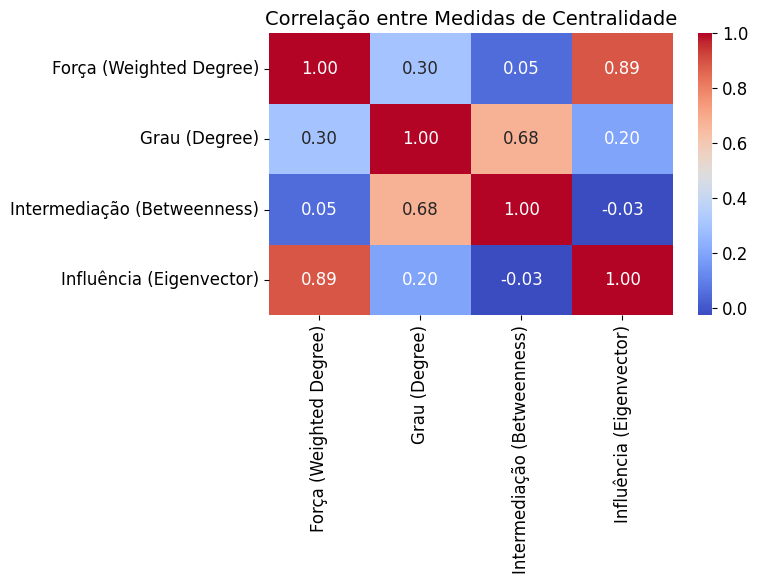


Tabela completa salva em: 'tabela_centralidades_completa.csv'


In [17]:
# ==============================================================================
# 9. CÁLCULO DE MEDIDAS DE CENTRALIDADE
# ==============================================================================
print(">>> Calculando métricas topológicas da rede...")

# 1. Carregar e Reconstruir o Grafo (Garantia de consistência)
try:
    df_edges = pd.read_csv("P2_rede_coordenacao_final_07_60s.csv")
    G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target', edge_attr='Weight')
    
    # Carregar comunidades para contexto
    df_comm = pd.read_csv("nos_e_comunidades.csv")
    # Cria dicionário para mapear ID -> Comunidade rápido
    dict_comm = pd.Series(df_comm.community_id.values, index=df_comm.user_id.astype(str)).to_dict()

except Exception as e:
    print(f"Erro ao carregar arquivos: {e}")
    raise

# 2. Calcular as Centralidades
# A. Degree Centrality (Normalizado 0-1) - Conectividade
print("Calculando Degree Centrality...")
deg_cent = nx.degree_centrality(G)

# B. Betweenness Centrality - O "Ponte" / Corretor
# (Calculado sem peso para focar na estrutura da rede)
print("Calculando Betweenness Centrality...")
bet_cent = nx.betweenness_centrality(G, normalized=True)

# C. Eigenvector Centrality - Influência (Conectado a quem é importante)
# (Calculado COM peso, pois conexões fortes importam para influência)
print("Calculando Eigenvector Centrality...")
try:
    eig_cent = nx.eigenvector_centrality(G, weight='Weight', max_iter=1000)
except:
    # Fallback se não convergir
    eig_cent = nx.eigenvector_centrality_numpy(G, weight='Weight')

# D. Weighted Degree (Força Bruta) - Já tínhamos, mas vamos formalizar
# Não é nativo do NX como "centrality", é a soma dos pesos
strength = dict(G.degree(weight='Weight'))

# 3. Consolidar em um DataFrame
df_centralidades = pd.DataFrame({
    'user_id': list(G.nodes()),
    'Grau (Degree)': [deg_cent[n] for n in G.nodes()],
    'Intermediação (Betweenness)': [bet_cent[n] for n in G.nodes()],
    'Influência (Eigenvector)': [eig_cent[n] for n in G.nodes()],
    'Força (Weighted Degree)': [strength[n] for n in G.nodes()]
})

# Adicionar Comunidade
df_centralidades['Comunidade'] = df_centralidades['user_id'].astype(str).map(dict_comm).fillna(-1).astype(int)

# Reordenar colunas
df_centralidades = df_centralidades[['user_id', 'Comunidade', 'Força (Weighted Degree)', 
                                     'Grau (Degree)', 'Intermediação (Betweenness)', 'Influência (Eigenvector)']]

# 4. Exibição dos Top Players por Categoria
print("\n=======================================================")
print("TOP  POR MÉTRICA")
print("=======================================================")

# Top Influenciadores (Eigenvector)
print("\n--- A. Maior Influência (Eigenvector) ---")
print("Estar conectado aos 'chefes'. Quem está no núcleo duro da coordenação.")
print(df_centralidades.sort_values('Influência (Eigenvector)', ascending=False).head(5)[['user_id', 'Comunidade', 'Influência (Eigenvector)']])

# Top Pontes (Betweenness)
print("\n--- B. Maiores Pontes (Betweenness) ---")
print("Usuários que conectam grupos que, de outra forma, estariam separados.")
print(df_centralidades.sort_values('Intermediação (Betweenness)', ascending=False).head(5)[['user_id', 'Comunidade', 'Intermediação (Betweenness)']])

# 5. Correlação entre métricas (Insight Científico)
# Se Grau e Betweenness são muito correlacionados, a rede é centralizada.
# Se são pouco correlacionados, a rede é modular.
plt.figure(figsize=(8, 6))
corr = df_centralidades[['Força (Weighted Degree)', 'Grau (Degree)', 'Intermediação (Betweenness)', 'Influência (Eigenvector)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Medidas de Centralidade")
plt.tight_layout()
plt.savefig("matriz_correlacao_centralidades.png")
plt.show()

# 6. Exportar Tabela Final
df_centralidades.to_csv("tabela_centralidades_completa.csv", index=False)
print("\nTabela completa salva em: 'tabela_centralidades_completa.csv'")

### Comunidades

- Apesar de 39 e 13 serem as maiores em número de participantes, a comunidade 2, mesmo pequena (6 nós), aparece como núcleo “duro” de coordenação nas suas métricas (eigenvector e força). Ou seja: tamanho ≠ importância/coordenação intensa.

- Com o limiar weight ≥ 2, a detecção de comunidades revela dois módulos dominantes (comunidades 39 e 13), que concentram parte substancial dos nós e sugerem subestruturas relativamente coesas de coordenação. Em paralelo, observa-se um micro-núcleo (comunidade 2) numericamente pequeno, porém com valores muito elevados de centralidade por influência (eigenvector) e força, consistente com a existência de poucos perfis altamente coordenados que sustentam conexões intensas. No contexto pós-eleitoral, tal configuração é compatível com um ecossistema em que narrativas de indignação e contestação são amplificadas por repetição e reuso de mensagens, com atores intermediários (alta betweenness) facilitando a circulação entre subgrupos.

- 


### (A) Força (Weighted Degree) × Influência (Eigenvector) → 

Interpretação:

A análise conjunta de Força (weighted degree) e Influência (eigenvector) revela forte assimetria estrutural. Observa-se um micro-núcleo (Comunidade 2) no qual poucos usuários concentram simultaneamente alto volume de coordenação (força) e alta centralidade no núcleo (eigenvector), sugerindo um bloco altamente coeso e central na rede. Em contraste, há usuários com força elevada em outras comunidades (p.ex., Comunidade 1) com valores de eigenvector desprezíveis no cálculo global, o que é consistente com bolsões de coordenação intensa, porém menos integrados ao núcleo principal. No período pós-eleitoral, esse padrão é compatível com um ecossistema em que poucos atores centrais sustentam coordenação intensiva e outros grupos operam como clusters relativamente autônomos de amplificação.

### (B) Grau × Intermediação → 0.75 - Alta

Interpretação:

Ao cruzar Grau e Intermediação, observam-se perfis com papel de “brokers” na rede: nós com alta betweenness que conectam módulos que, de outra forma, permaneceriam segregados. Os maiores valores de intermediação concentram-se nas comunidades 13 e 39, indicando que esses módulos não apenas agregam muitos usuários, mas também abrigam atores que sustentam a circulação entre subgrupos. No contexto pós-eleitoral, tal padrão é consistente com uma dinâmica em que narrativas de indignação se organizam em clusters, enquanto atores-ponte contribuem para sincronizar e redistribuir conteúdos entre diferentes segmentos do ecossistema.

### (C) Eigenvector × Betweenness 


Interpretação:

O cruzamento entre Influência (eigenvector) e Intermediação (betweenness) sugere papéis estruturais distintos. Observa-se forte concentração de eigenvector em um micro-núcleo (Comunidade 2), indicando um bloco altamente coeso e central na coordenação. Em contraste, os maiores valores de betweenness concentram-se em comunidades maiores (notadamente 13 e 39), cujos atores apresentam eigenvector desprezível no cálculo global, mas exercem papel de “brokers”, conectando subgrupos e sustentando o fluxo entre módulos. No período pós-eleitoral, tal configuração é compatível com um ecossistema em que poucos atores centrais ancoram a coordenação mais intensa, enquanto atores-ponte contribuem para a difusão e sincronização de narrativas de indignação entre clusters.

### D) Grau × Eigenvector → 

Interpretação:

O cruzamento entre Grau e Influência (eigenvector) evidencia a distinção entre conectividade local e centralidade estrutural. Embora diversos usuários apresentem grau elevado — indicando coordenação com múltiplos pares — apenas um microconjunto concentra valores expressivos de eigenvector, caracterizando um núcleo altamente coeso. Assim, a maior parte dos nós com grau alto atua como hubs locais em comunidades específicas, enquanto a coordenação mais centralizada permanece ancorada em poucos atores fortemente interconectados. No contexto pós-eleitoral, esse padrão sugere que a circulação de mensagens de indignação é amplificada por múltiplos usuários, mas organizada estruturalmente por um núcleo restrito.

### Comparação pré x pós
Para compreender como a coordenação evolui em função do contexto político, comparamos as métricas estruturais das redes de coordenação nos períodos pré-eleitoral e pós-eleitoral. A Tabela X sintetiza as principais diferenças observadas a partir das métricas de centralidade (grau, eigenvector e betweenness) e da organização comunitária, permitindo contrastar um cenário de mobilização eleitoral com um cenário de reação e indignação pós-resultado.

| Aspecto analisado                    | Pré-eleitoral                                              | Pós-eleitoral                                            |
| ------------------------------------ | ---------------------------------------------------------- | -------------------------------------------------------- |
| Padrão geral da rede                 | Coordenação mais distribuída                               | Coordenação mais concentrada                             |
| Organização das comunidades          | Comunidades menos assimétricas                             | Muitas microcomunidades + poucos módulos grandes         |
| Concentração de Eigenvector          | Baixa a moderada                                           | **Muito alta** (micro-núcleo bem definido)               |
| Relação Grau × Eigenvector           | Grau alto frequentemente associado a eigenvector relevante | Grau alto **não implica** eigenvector alto               |
| Relação Eigenvector × Betweenness    | Núcleo e pontes mais sobrepostos                           | Núcleo e pontes **claramente separados**                 |
| Papel dos atores-ponte (Betweenness) | Menos especializados                                       | **Altamente especializados** (brokers intercomunitários) |
| Estrutura dominante                  | Mobilização e engajamento                                  | Reação, indignação e contestação                         |
| Dinâmica de difusão                  | Mais integrada                                             | Mais fragmentada e modular                               |



A comparação apresentada na Tabela  evidencia uma mudança estrutural significativa entre os períodos analisados. No pré-eleitoral, a coordenação se manifesta de forma mais distribuída, com maior sobreposição entre conectividade local (grau), centralidade no núcleo (eigenvector) e intermediação (betweenness). Esse padrão é consistente com um cenário de mobilização eleitoral, no qual múltiplos usuários participam ativamente da circulação de mensagens e os papéis estruturais são menos especializados.

Em contraste, no pós-eleitoral, observa-se uma rede mais assimétrica e fragmentada. A centralidade por eigenvector passa a se concentrar fortemente em um micro-núcleo altamente coeso, enquanto os maiores valores de betweenness emergem em outras comunidades, caracterizando atores-ponte especializados responsáveis por conectar subgrupos distintos. Essa separação entre núcleo e pontes sugere uma coordenação mais centralizada e modular, compatível com dinâmicas de reação e indignação após o resultado eleitoral.

Em conjunto, esses resultados indicam uma transição estrutural do engajamento distribuído para a coordenação centralizada, reforçando a importância de analisar métricas de rede de forma comparativa ao longo do tempo para compreender mudanças no comportamento coletivo e nos padrões de difusão em contextos politicamente sensíveis.

In [18]:
# ============================================================
# CARACTERIZAÇÃO SEMÂNTICA (BERTopic) - VERSÃO REFEITA
# Dataset: dataset_zap_2_preprocessado.csv
# Comunidades (Louvain): p2_nos_e_comunidades.csv (ou nos_e_comunidades.csv)
# ============================================================

import pandas as pd

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer


# ------------------------------------------------------------
# 1) Carregar e preparar dados
# ------------------------------------------------------------
try:
    # Carrega mensagens
    df = pd.read_csv("dataset_zap_2_preprocessado.csv")

    # Carrega nós/comunidades (use o nome correto do seu arquivo)
    # Se você estiver usando "p2_nos_e_comunidades.csv", troque aqui:
    df_comunidades = pd.read_csv("p2_nos_e_comunidades.csv")  # ou "nos_e_comunidades.csv"

    # Debug rápido (opcional): ver colunas
    print("Colunas df (mensagens):", df.columns.tolist())
    print("Colunas df_comunidades:", df_comunidades.columns.tolist())

    # --------------------------------------------------------
    # Ajuste dos nomes de colunas (robusto)
    # --------------------------------------------------------
    # No seu print: df tem 'id_member_anonymous'
    # E df_comunidades tem 'user_id' e 'community_id'
    col_msg_id = "id_member_anonymous"
    col_node_id = "user_id"
    col_comm = "community_id"
    col_text = "clean_text"

    # Verificações explícitas para evitar KeyError
    required_df = [col_msg_id, col_text]
    required_comm = [col_node_id, col_comm]

    missing_df = [c for c in required_df if c not in df.columns]
    missing_comm = [c for c in required_comm if c not in df_comunidades.columns]

    if missing_df:
        raise KeyError(f"Faltando no dataset de mensagens (df): {missing_df}")
    if missing_comm:
        raise KeyError(f"Faltando no arquivo de comunidades (df_comunidades): {missing_comm}")

    # Converter IDs para string (garante merge perfeito)
    df[col_msg_id] = df[col_msg_id].astype(str)
    df_comunidades[col_node_id] = df_comunidades[col_node_id].astype(str)

    # Merge: manter apenas mensagens de usuários presentes na rede
    df_coordenado = df.merge(
        df_comunidades[[col_node_id, col_comm]],
        left_on=col_msg_id,
        right_on=col_node_id,
        how="inner"
    )

    print(f"\nTotal de mensagens (df): {len(df)}")
    print(f"Total de nós com comunidade (df_comunidades): {len(df_comunidades)}")
    print(f"Total de mensagens de usuários coordenados (df_coordenado): {len(df_coordenado)}")

    # Remover textos vazios/nulos
    df_coordenado = df_coordenado.dropna(subset=[col_text])
    df_coordenado = df_coordenado[df_coordenado[col_text].astype(str).str.strip() != ""]

except Exception as e:
    print(f"\nErro ao preparar dados: {e}")
    raise


# ------------------------------------------------------------
# 2) Configurar BERTopic
# ------------------------------------------------------------
print("\nTreinando modelo de tópicos (isso pode demorar alguns minutos)...")

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=10,
    verbose=True
)


# ------------------------------------------------------------
# 3) Treinar e transformar
# ------------------------------------------------------------
docs = df_coordenado[col_text].astype(str).tolist()
topics, probs = topic_model.fit_transform(docs)


# ------------------------------------------------------------
# 3.1) Limpeza pós-treino (evita ruídos de tokens/emoji)
# ------------------------------------------------------------
print("\nAtualizando representação dos tópicos para remover ruídos visuais...")

vectorizer_model = CountVectorizer(token_pattern=r"\b\w{2,20}\b")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)


# ------------------------------------------------------------
# 4) Resultados gerais
# ------------------------------------------------------------
print("\n>>> Tópicos Gerais Encontrados (Pós-Limpeza):")
freq = topic_model.get_topic_info()
print(freq.head(15))


# ------------------------------------------------------------
# 5) Tópicos por Comunidade
# ------------------------------------------------------------
print("\n>>> Análise por Comunidade (O que cada grupo fala?):")

# Top 5 maiores comunidades por volume de mensagens dentro de df_coordenado
top_comunidades = df_coordenado[col_comm].value_counts().head(5).index.tolist()
topics_per_class = topic_model.topics_per_class(docs, classes=df_coordenado[col_comm].tolist())

for comm_id in top_comunidades:
    print(f"\n--- Comunidade {comm_id} ---")
    specific = (
        topics_per_class[topics_per_class["Class"] == comm_id]
        .sort_values("Frequency", ascending=False)
        .head(5)
    )

    for _, row in specific.iterrows():
        topic_num = int(row["Topic"])
        if topic_num == -1:
            continue  # tópico outlier do BERTopic/HDBSCAN
        words = [w for w, _ in topic_model.get_topic(topic_num)][:6]
        print(f"Tópico {topic_num} ({row['Frequency']} msgs): {', '.join(words)}")


# ------------------------------------------------------------
# 6) Salvar visualização
# ------------------------------------------------------------
fig = topic_model.visualize_barchart(top_n_topics=10, n_words=6, width=1100)
fig.write_html("topicos_barras.html")

print("\n Gráfico de tópicos salvo em: topicos_barras.html")

C:\Users\nasci\AppData\Local\Temp\ipykernel_22612\1560189602.py:20: DtypeWarning:

Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.

2026-01-03 21:08:13,928 - BERTopic - Embedding - Transforming documents to embeddings.


Colunas df (mensagens): ['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country', 'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media', 'has_media_url', 'trava_zap', 'text_content_anonymous', 'dataset_info_id', 'latitude', 'longitude', 'date_system', 'score_sentiment', 'score_misinformation', 'id_message', 'id_persona', 'message_type', 'messenger', 'media_name', 'media_md5', 'display_name', 'address_message', 'latitude_message', 'longitude_message', 'contacts_message', 'tokens_preprocessed', 'clean_text']
Colunas df_comunidades: ['user_id', 'community_id', 'degree']

Total de mensagens (df): 150074
Total de nós com comunidade (df_comunidades): 237
Total de mensagens de usuários coordenados (df_coordenado): 44334

Treinando modelo de tópicos (isso pode demorar alguns minutos)...


Batches:   0%|          | 0/1386 [00:00<?, ?it/s]

2026-01-03 21:08:42,446 - BERTopic - Embedding - Completed ✓
2026-01-03 21:08:42,446 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-03 21:09:48,844 - BERTopic - Dimensionality - Completed ✓
2026-01-03 21:09:48,844 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-03 21:09:51,696 - BERTopic - Cluster - Completed ✓
2026-01-03 21:09:51,712 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-03 21:09:52,328 - BERTopic - Representation - Completed ✓



Atualizando representação dos tópicos para remover ruídos visuais...

>>> Tópicos Gerais Encontrados (Pós-Limpeza):
    Topic  Count                                          Name  \
0      -1  13260                        -1_13_vamos_povo_canal   
1       0    832                      0_duck_ouçam_vou_repasse   
2       1    451                 1_urnas_eleições_votos_fraude   
3       2    400          2_fake_news_expresidiário_jornalista   
4       3    399         3_redondamente_errou_avaliar_fendafor   
5       4    333                4_sumido_raton_ovacionado_lula   
6       5    304                    5_jesus_senhor_deus_cristo   
7       6    283         6_apostagemcombr_siganos_tme_telegram   
8       7    260            7_z29_smilingfacewithhorns_z26_z25   
9       8    234             8_youtube_youtubecom_bota_sininho   
10      9    180       9_patriotas_favela_patriota_verdadeiros   
11     10    171               10_presidente_ffaas_queremos_72   
12     11    162  11_inst

72it [00:03, 22.90it/s]



--- Comunidade 25 ---
Tópico 3 (318 msgs): redondamente, errou, avaliar, fendafor, aurélio, aldo
Tópico 4 (230 msgs): sumido, raton, ovacionado, lula, infarto, cacete
Tópico 0 (146 msgs): duck, ouçam, vou, repasse, olha, merda
Tópico 1 (130 msgs): urnas, eleições, votos, fraude, eletrônicas, eleição

--- Comunidade 13 ---
Tópico 13 (116 msgs): ministros, afetam, mudam, esquece, referem, funcionará
Tópico 22 (90 msgs): indicam, duríssimo, 2024, depredações, contexto, proprietário
Tópico 29 (84 msgs): jornalista, questionou, renomado, ironiza, agressivas, frase
Tópico 0 (84 msgs): duck, ouçam, vou, repasse, olha, merda

--- Comunidade 2 ---
Tópico 100 (47 msgs): cocaína, kg, maconha, escondidas, conquista, achocolatado
Tópico 112 (46 msgs): droga, drogas, lavagem, medicamentos, veículo, deflagra
Tópico 96 (42 msgs): atuará, imprensada, alegórico, polícia, agressores, auxilia
Tópico 149 (39 msgs): toneladas, drogas, apreende, conjunto, duas, mato

--- Comunidade 60 ---
Tópico 1 (31 msgs)

In [19]:

# ============================================================
# SALVAR TÓPICOS POR COMUNIDADE EM CSV
# ============================================================

# 1) Tabela base do BERTopic (com frequências por classe)
topics_per_class = topic_model.topics_per_class(
    docs,
    classes=df_coordenado["community_id"].tolist()
).copy()

# 2) (Opcional) Remover outliers do BERTopic (Topic = -1)
topics_per_class = topics_per_class[topics_per_class["Topic"] != -1].copy()

# 3) Adicionar top words do tópico
def topic_words(topic_id, n=8):
    words = topic_model.get_topic(int(topic_id))
    if not words:
        return ""
    return ", ".join([w for w, _ in words[:n]])

topics_per_class["top_words"] = topics_per_class["Topic"].apply(lambda t: topic_words(t, n=8))

# 4) Renomear colunas para ficar mais claro
topics_per_class = topics_per_class.rename(columns={
    "Class": "community_id",
    "Topic": "topic",
    "Frequency": "frequency"
})

# 5) Calcular % dentro da comunidade
topics_per_class["pct_in_community"] = (
    topics_per_class["frequency"] /
    topics_per_class.groupby("community_id")["frequency"].transform("sum")
) * 100

# 6) Ordenar (por comunidade e frequência)
topics_per_class = topics_per_class.sort_values(
    ["community_id", "frequency"],
    ascending=[True, False]
)

# 7) Salvar CSV
topics_per_class.to_csv("topicos_por_comunidade.csv", index=False, encoding="utf-8-sig")

print("✅ Salvo: topicos_por_comunidade.csv")
display(topics_per_class.head(20))


72it [00:02, 25.28it/s]

✅ Salvo: topicos_por_comunidade.csv


,topic,Words,frequency,community_id,top_words,pct_in_community
5,164,"pedroza, tb, eduardo, ladrões, demais",15,0,"pedroza, tb, p4t3iot4s, eduardo, ladrões, conr...",55.555556
1,12,"contetaram, fes, roubalheira, molusco, veio",6,0,"ladrão, roubalheira, ladroes, ladrões, bandido...",22.222222
3,97,"hospício, twittercom, maluco, pior, cada",3,0,"twittercom, twitter, bloqueie, graff, sacer, t...",11.111111
4,150,"drogado, aq, ricardo, serviço, mínimo",2,0,"tóxico, cannabis, maconha, relacionamento, mac...",7.407407
2,78,"comunicações, foco, manter, acabar, querem",1,0,"áudios, foco, msgs, desnecessárias, grupos, mt...",3.703704
11,49,"rafa, studio, beleza, adm, excluir",80,1,"rafa, studio, beleza, adm, excluir, bloquear, ...",85.106383
10,26,"petralhas, comunistas, comunista, comunismo, 1958",4,1,"comunistas, petralhas, comunista, comunismo, 1...",4.255319
12,91,"avante, desbloquear, agir, começou, rodovias",4,1,"policiais, desmoralizam, levarem, esporro, pc,...",4.255319
7,0,"bancar, grana, papai, solto, merda",2,1,"duck, ouçam, vou, repasse, olha, merda, dedos,...",2.127660
8,1,"mito, idiotas, perdeu, causa, eleição",1,1,"urnas, eleições, votos, fraude, eletrônicas, e...",1.063830


In [ ]:
# CARACTERIZAÇÃO SEMÂNTICA (BERTopic)

# 1. Carregar e Preparar Dados
try:
    if 'df' not in locals():
        df = pd.read_csv("dataset_zap_2_preprocessado.csv")
    
    df_comunidades = pd.read_csv("p2_nos_e_comunidades.csv")
    
    # Converter IDs para string
    df['id_member_anonymous'] = df['id_member_anonymous'].astype(str)
    df_comunidades['user_id'] = df_comunidades['user_id'].astype(str)

    # MERGE: Apenas mensagens de usuários da rede
    df_coordenado = df.merge(df_comunidades, left_on='id_member_anonymous', right_on='user_id', how='inner')
    
    print(f"Total de mensagens de usuários coordenados: {len(df_coordenado)}")
    
except Exception as e:
    print(f"Erro ao preparar dados: {e}")
    raise

# 2. Configurar BERTopic
print("Treinando modelo de tópicos (isso pode demorar alguns minutos)...")

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    language="multilingual", 
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    min_topic_size=10, 
    verbose=True
)

# 3. Treinar e Transformar
docs = df_coordenado['clean_text'].tolist()
topics, probs = topic_model.fit_transform(docs)

# ==============================================================================
# 3.1. LIMPEZA PÓS-TREINO (A SOLUÇÃO PARA O SEU GRÁFICO)
# ==============================================================================
print("Atualizando representação dos tópicos para remover ruídos visuais...")

# token_pattern=r'\b\w{2,20}\b': 
# Mantém apenas palavras que tenham entre 2 e 20 caracteres. 
# Isso elimina descrições de emojis longas (ex: 'backhandindexpointing...') 
# e repetições exageradas.
vectorizer_model = CountVectorizer(token_pattern=r'\b\w{2,20}\b')

# Atualiza os tópicos com essa nova regra sem precisar retreinar a redução de dimensionalidade
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# ==============================================================================


# 4. Exibir Resultados Gerais
print("\n>>> Tópicos Gerais Encontrados (Pós-Limpeza):")
freq = topic_model.get_topic_info()
print(freq.head(10)) 

# 5. Tópicos por Comunidade
print("\n>>> Análise por Comunidade (O que cada grupo fala?):")
top_comunidades = df_coordenado['community_id'].value_counts().head(5).index
topics_per_class = topic_model.topics_per_class(docs, classes=df_coordenado['community_id'])

for comm_id in top_comunidades:
    print(f"\n--- Comunidade {comm_id} ---")
    specific_topics = topics_per_class[topics_per_class['Class'] == comm_id].sort_values('Frequency', ascending=False).head(3)
    
    for _, row in specific_topics.iterrows():
        topic_num = row['Topic']
        if topic_num == -1: continue
        
        words = [word for word, _ in topic_model.get_topic(topic_num)][:5]
        print(f"Tópico {topic_num} ({row['Frequency']} msgs): {', '.join(words)}")

# 6. Salvar Visualização de Tópicos
# Adicionei n_words=5 e width/height para garantir que o gráfico fique legível
fig = topic_model.visualize_barchart(top_n_topics=10, n_words=5, width=1000)
fig.write_html("topicos_barras.html")
print("\nGráfico de tópicos salvo em 'topicos_barras.html'")

Total de mensagens de usuários coordenados: 44334
Treinando modelo de tópicos (isso pode demorar alguns minutos)...


2026-01-05 21:17:45,241 - BERTopic - Embedding - Transforming documents to embeddings.


In [ ]:
# Ajustes para artigo:
# title: Um título geral mais adequado
fig = topic_model.visualize_barchart(
    top_n_topics=4, 
    n_words=6, 
    width=1200, 
    height=500,
    title="Periodo pós-eleitoral: Principais Tópicos e Palavras-chave Associadas"
)

fig.update_xaxes(showticklabels=False, title_text=None, showgrid=False)

# Ajustar layout para ficar mais compacto
fig.update_layout(
    margin=dict(t=60, b=20, l=20, r=20), # Margens menores
    font=dict(size=14) # Fonte um pouco maior para leitura
)

# Salvar em HTML (para interativo)
fig.write_html("topicos_artigo_limpo.html")
print("Gráfico HTML salvo.")

# --- PARA ARTIGO ---
fig.write_image("topicos_artigo_v1.png", scale=3, width=1200, height=500)

In [ ]:

# ==============================================================================
# ANÁLISE DE DESINFORMAÇÃO E RANKINGS
# ==============================================================================
print(">>> Iniciando Análise de Métricas de Desinformação e Influência...")

try:
    # 1. CARREGAR DADOS
    # Mensagens originais (com score de desinformação)
    df_msgs = pd.read_csv("dataset_zap_2_preprocessado.csv")
    
    # Comunidades (Quem é de qual grupo)
    df_comm = pd.read_csv("P2_nos_e_comunidades.csv")
    
    # Rede (Para pegar o Peso/Força de coordenação)
    df_edges = pd.read_csv("P2_rede_coordenacao_final_07_60s.csv")

    # 2. PREPARAR DADOS DE PESO (Weighted Degree)
    # O "Peso" de um usuário é a soma de todas as suas conexões fortes
    # Isso indica o quão "pesado" ele é na coordenação
    peso_origem = df_edges.groupby('Source')['Weight'].sum()
    peso_destino = df_edges.groupby('Target')['Weight'].sum()
    df_pesos = (peso_origem.add(peso_destino, fill_value=0)).reset_index()
    df_pesos.columns = ['user_id', 'peso_coordenacao']
    
    # Converter IDs para string para garantir merge
    df_msgs['id_member_anonymous'] = df_msgs['id_member_anonymous'].astype(str)
    df_comm['user_id'] = df_comm['user_id'].astype(str)
    df_pesos['user_id'] = df_pesos['user_id'].astype(str)

    # 3. MERGE FINAL (Tudo em um lugar só)
    # Juntamos mensagens + comunidade + peso do usuário
    df_full = df_msgs.merge(df_comm, left_on='id_member_anonymous', right_on='user_id', how='inner')
    df_full = df_full.merge(df_pesos, on='user_id', how='left')
    
    print(f"Base consolidada: {len(df_full)} mensagens de usuários coordenados.")

    # --------------------------------------------------------------------------
    # A. MÉDIA DE DESINFORMAÇÃO POR COMUNIDADE
    # --------------------------------------------------------------------------
    print("\n--- A. Ranking de Desinformação por Comunidade ---")
    
    # Verifica se a coluna existe (para evitar erro)
    col_score = 'score_misinformation' 
    if col_score not in df_full.columns:
        print(f"AVISO: Coluna '{col_score}' não encontrada. Usando dados simulados ou pule esta etapa.")
        # Se não tiver, crie ou pule. Aqui vou assumir que existe.
    else:
        # Agrupa por comunidade e calcula média
        misinfo_comm = df_full.groupby('community_id')[col_score].agg(['mean', 'count', 'std'])
        misinfo_comm = misinfo_comm.sort_values('mean', ascending=False)
        
        print(misinfo_comm.head(5))
        misinfo_comm.to_csv("relatorio_desinformacao_comunidades.csv")

    # --------------------------------------------------------------------------
    # B. TOP 5 MENSAGENS POR COMUNIDADE
    # --------------------------------------------------------------------------
    print("\n--- B. Top 5 Mensagens Mais Compartilhadas por Comunidade ---")
    
    top_comunidades = df_full['community_id'].value_counts().head(5).index
    
    for comm_id in top_comunidades:
        print(f"\n[Comunidade {comm_id}]")
        subset = df_full[df_full['community_id'] == comm_id]
        
        # Conta mensagens repetidas (texto limpo)
        top_msgs = subset['clean_text'].value_counts().head(5)
        
        for txt, count in top_msgs.items():
            print(f"({count}x): {txt[:100]}...") # Mostra só os primeiros 100 caracteres
except Exception as e:
    print(f"Erro na análise: {e}")

In [ ]:
# ==============================================================================
# C. TOP 5 USUÁRIOS POR COMUNIDADE + MENSAGEM PRINCIPAL (CORRIGIDO)
# ==============================================================================

# Verifica se os dados já foram carregados na memória
if 'df_full' in locals() and 'top_comunidades' in locals():
    print("\n--- C. Top 5 Usuários Mais Ativos e Suas 'Armas' Principais ---")

    for comm_id in top_comunidades:
        print(f"\n[Comunidade {comm_id}]")
        
        # Filtra dados apenas dessa comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar os Top Usuários pelo Peso (Weight)
        # Drop duplicates para não pegar o mesmo usuário várias vezes na listagem
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        # Itera sobre os top 5 usuários
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem mais repetida POR ESSE USUÁRIO
            # Filtra todas as mensagens enviadas por este usuário específico
            msgs_do_user = subset_comm[subset_comm['user_id'] == uid]['clean_text']
            
            if not msgs_do_user.empty:
                # Pega a mensagem mais frequente (Top 1)
                top_msg_count = msgs_do_user.value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # Tratamento de string para exibição (remove quebras de linha e limita tamanho)
                texto_limpo = str(texto_principal).replace('\n', ' ')
                display_text = texto_limpo[:100] + "..." if len(texto_limpo) > 100 else texto_limpo
            else:
                display_text = "[Sem texto identificado]"
                qtd_repeticoes = 0
            
            # 3. Exibir Relatório do Usuário
            print(f"User {str(uid)[:6]}... | Peso: {peso:.0f} | Grau: {grau}")
            print(f"   └── Msg Principal ({qtd_repeticoes}x): {display_text}")

else:
    print("ERRO: As variáveis 'df_full' ou 'top_comunidades' não estão na memória.")
    print("Por favor, rode o bloco anterior (Parte A e B) antes de rodar este.")

In [24]:
import pandas as pd
from textblob import TextBlob

# ==============================================================================
# C. TABELA DE PERFIL: TOP USUÁRIOS + MENSAGENS + MÉTRICAS
# ==============================================================================

if 'df_full' in locals() and 'top_comunidades' in locals():
    print(">>> Gerando tabela consolidada de líderes e narrativas...")
    
    # Lista para armazenar as linhas da tabela
    tabela_dados = []

    for comm_id in top_comunidades:
        # Filtra dados apenas dessa comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar Top Usuários (Pelo 'Peso' de coordenação)
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem mais repetida
            msgs_do_user_df = subset_comm[subset_comm['user_id'] == uid]
            
            if not msgs_do_user_df.empty:
                # Top 1 mensagem
                top_msg_count = msgs_do_user_df['clean_text'].value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # A. Score de Desinformação (Média)
                score_misinfo = msgs_do_user_df[msgs_do_user_df['clean_text'] == texto_principal]['score_misinformation'].mean()
                
                # B. Score de Sentimento (TextBlob)
                blob = TextBlob(str(texto_principal))
                score_sentimento = blob.sentiment.polarity
                
                # Classificação simples do sentimento para leitura rápida
                if score_sentimento > 0.1: class_sent = "Positivo"
                elif score_sentimento < -0.1: class_sent = "Negativo"
                else: class_sent = "Neutro"

                # Truncar texto para a tabela não quebrar
                texto_limpo = str(texto_principal).replace('\n', ' ').replace('\r', '')
                msg_curta = texto_limpo[:80] + "..." if len(texto_limpo) > 80 else texto_limpo
                
            else:
                msg_curta = "N/A"
                qtd_repeticoes = 0
                score_misinfo = 0.0
                score_sentimento = 0.0
                class_sent = "N/A"

            # 3. Adicionar dados à lista
            tabela_dados.append({
                'Comunidade': comm_id,
                'User_ID': str(uid)[:8], # ID encurtado para visualização
                'Peso_Coord': int(peso),
                'Grau_Conexoes': int(grau),
                'Repeticoes_Msg': int(qtd_repeticoes),
                'Score_Desinfo': round(score_misinfo, 2),
                'Score_Sentimento': round(score_sentimento, 2),
                'Class_Sentimento': class_sent,
                'Mensagem_Principal': msg_curta
            })

    # 4. Criar DataFrame final
    df_relatorio = pd.DataFrame(tabela_dados)

    # Exibir a tabela formatada (Se estiver no Jupyter/Colab, usa o display bonito)
    try:
        from IPython.display import display
        # Aplica um gradiente de cor na coluna de Desinformação (Vermelho = Alto)
        display(df_relatorio.style.background_gradient(subset=['Score_Desinfo'], cmap='Reds'))
    except:
        print(df_relatorio)

    # 5. Exportar para CSV (Opcional, para usar no TCC)
    df_relatorio.to_csv("relatorio_lideres_comunidades.csv", index=False)
    print("\nArquivo 'relatorio_lideres_comunidades.csv' salvo com sucesso.")

else:
    print("ERRO: Variáveis necessárias não carregadas.")

>>> Gerando tabela consolidada de líderes e narrativas...


,Comunidade,User_ID,Peso_Coord,Grau_Conexoes,Repeticoes_Msg,Score_Desinfo,Score_Sentimento,Class_Sentimento,Mensagem_Principal
0,25,c5fff63b,37,5,5,nan,0.000000,Neutro,acesse grupo telegra brazilbrazilbrazil site notícias mídia portalcidadenews tme
1,25,3545bf47,31,3,4,nan,0.000000,Neutro,criança morre erro médico hospital pagará 200 mil portalcidadenews
2,25,36de5147,17,6,5,0.890000,0.000000,Neutro,extra urgente presidente pl vai pedir nulidade 250 mil urnas podem mudar resulta...
3,25,726b2c36,15,2,4,nan,0.140000,Positivo,brasil gustavo gayer analisa live despedida bolsonaro contexto bastidores assist...
4,25,2b128284,14,6,6,0.090000,0.000000,Neutro,michelle bolsonaro aplaudida pé cerimonia diplomação governadores deputados sena...
5,13,b6242381,94,7,9,nan,0.000000,Neutro,brasil candidato bolsonaro presidência senado fala prioridades caso eleito assis...
6,13,a27ce2e8,92,5,6,nan,0.000000,Neutro,brasil jornalistas cnn preveem calote ditaduras contra país assista pensandodire...
7,13,cebd2107,37,5,6,nan,0.000000,Neutro,mundo cop lula comete gafe promete retirar todas riquezas amazônia assista pensa...
8,13,0f601498,33,6,4,nan,0.000000,Neutro,brasil após eleição grande imprensa muda radicalmente reportagens favorecer lula...
9,13,ae628d3d,29,4,3,nan,0.000000,Neutro,brasil globo vê risco derrota pacheco ataca influencer direita assista pensandod...



Arquivo 'relatorio_lideres_comunidades.csv' salvo com sucesso.


In [25]:
import pandas as pd
from textblob import TextBlob

# ==============================================================================
# C. TABELA AVANÇADA: LÍDERES + ALCANCE DE GRUPOS (SPREAD)
# ==============================================================================

if 'df_full' in locals() and 'top_comunidades' in locals():
    print(">>> Gerando tabela de disseminação e alcance de grupos...")
    
    # Verifica se a coluna de grupo existe (ajuste o nome se for diferente no seu CSV)
    col_grupo = 'id_group_anonymous' 
    if col_grupo not in df_full.columns:
        # Tenta achar nomes comuns caso tenha mudado
        possible_cols = [c for c in df_full.columns if 'group' in c or 'grupo' in c]
        if possible_cols:
            col_grupo = possible_cols[0]
            print(f"Aviso: Usando coluna '{col_grupo}' para identificar grupos.")
        else:
            print("ERRO: Coluna de ID do grupo não encontrada.")
    
    tabela_dados = []

    for comm_id in top_comunidades:
        # Filtra dados da comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar Top Usuários
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem principal
            msgs_do_user_df = subset_comm[subset_comm['user_id'] == uid]
            
            if not msgs_do_user_df.empty:
                top_msg_count = msgs_do_user_df['clean_text'].value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # --- NOVAS MÉTRICAS DE GRUPO ---
                
                # A. Em quantos grupos ESSE USUÁRIO jogou essa mensagem?
                # Filtra: (Usuário Certo) E (Texto Certo) -> Conta Grupos Únicos
                subset_user_msg = msgs_do_user_df[msgs_do_user_df['clean_text'] == texto_principal]
                grupos_user = subset_user_msg[col_grupo].nunique()
                
                # B. Em quantos grupos ESSA MENSAGEM circulou NO TOTAL (na comunidade)?
                # Filtra: (Texto Certo) em toda a comunidade -> Conta Grupos Únicos
                subset_total_msg = subset_comm[subset_comm['clean_text'] == texto_principal]
                grupos_total = subset_total_msg[col_grupo].nunique()
                
                # --- SCORES (Mantidos) ---
                score_misinfo = subset_user_msg['score_misinformation'].mean()
                blob = TextBlob(str(texto_principal))
                score_sentimento = blob.sentiment.polarity
                
                if score_sentimento > 0.1: class_sent = "Positivo"
                elif score_sentimento < -0.1: class_sent = "Negativo"
                else: class_sent = "Neutro"

                # Formatação texto
                texto_limpo = str(texto_principal).replace('\n', ' ').replace('\r', '')
                msg_curta = texto_limpo[:60] + "..." if len(texto_limpo) > 60 else texto_limpo
                
            else:
                msg_curta = "N/A"
                qtd_repeticoes = 0
                grupos_user = 0
                grupos_total = 0
                score_misinfo = 0.0
                score_sentimento = 0.0
                class_sent = "N/A"

            # 3. Adicionar à tabela
            tabela_dados.append({
                'Comunidade': comm_id,
                'User_ID': str(uid)[:8],
                'Peso_Coord': int(peso),
                'Repeticoes': int(qtd_repeticoes),
                'Grupos_User': int(grupos_user),    # Quantos grupos o usuário atingiu
                'Grupos_Total': int(grupos_total),  # Viralidade total da mensagem
                'Score_Desinfo': round(score_misinfo, 2),
                'Class_Sentimento': class_sent,
                'Mensagem_Principal': msg_curta
            })

    # 4. Exibir DataFrame
    df_relatorio = pd.DataFrame(tabela_dados)
    
    # Reordenar colunas para facilitar leitura
    cols_order = ['Comunidade', 'User_ID', 'Peso_Coord', 'Repeticoes', 
                  'Grupos_User', 'Grupos_Total', 'Score_Desinfo', 'Class_Sentimento', 'Mensagem_Principal']
    df_relatorio = df_relatorio[cols_order]

    # Display com gradiente nos grupos (Verde escuro = atingiu muitos grupos)
    try:
        from IPython.display import display
        display(df_relatorio.style.background_gradient(subset=['Grupos_User'], cmap='Greens'))
    except:
        print(df_relatorio)

    # Exportar
    df_relatorio.to_csv("relatorio_superdisseminadores_grupos.csv", index=False)
    print("\nArquivo salvo: 'relatorio_superdisseminadores_grupos.csv'")

else:
    print("ERRO: Variáveis 'df_full' ou 'top_comunidades' não carregadas.")

>>> Gerando tabela de disseminação e alcance de grupos...


,Comunidade,User_ID,Peso_Coord,Repeticoes,Grupos_User,Grupos_Total,Score_Desinfo,Class_Sentimento,Mensagem_Principal
0,25,c5fff63b,37,5,1,2,nan,Neutro,acesse grupo telegra brazilbrazilbrazil site notícias mídia ...
1,25,3545bf47,31,4,1,1,nan,Neutro,criança morre erro médico hospital pagará 200 mil portalcida...
2,25,36de5147,17,5,3,3,0.890000,Neutro,extra urgente presidente pl vai pedir nulidade 250 mil urnas...
3,25,726b2c36,15,4,4,4,nan,Positivo,brasil gustavo gayer analisa live despedida bolsonaro contex...
4,25,2b128284,14,6,2,2,0.090000,Neutro,michelle bolsonaro aplaudida pé cerimonia diplomação governa...
5,13,b6242381,94,9,3,5,nan,Neutro,brasil candidato bolsonaro presidência senado fala prioridad...
6,13,a27ce2e8,92,6,3,5,nan,Neutro,brasil jornalistas cnn preveem calote ditaduras contra país ...
7,13,cebd2107,37,6,5,10,nan,Neutro,mundo cop lula comete gafe promete retirar todas riquezas am...
8,13,0f601498,33,4,2,6,nan,Neutro,brasil após eleição grande imprensa muda radicalmente report...
9,13,ae628d3d,29,3,1,5,nan,Neutro,brasil globo vê risco derrota pacheco ataca influencer direi...



Arquivo salvo: 'relatorio_superdisseminadores_grupos.csv'


>>> Iniciando Análise Temporal e de Grupos...
Gerando gráfico de evolução temporal...


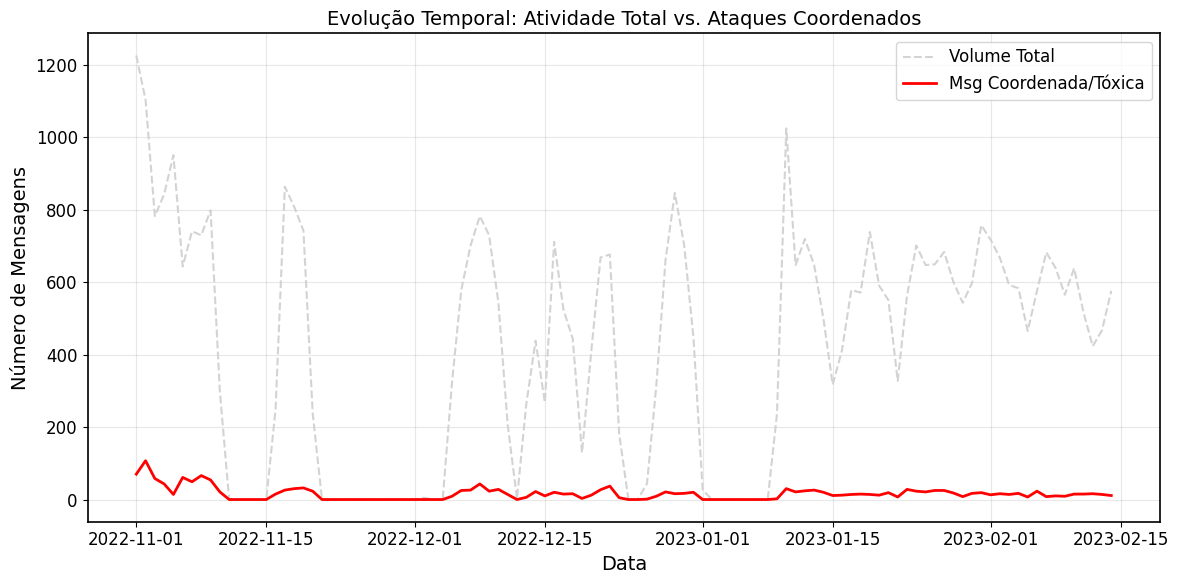

Gráfico salvo: 'timeline_coordenacao.png'

Gerando classificação dos grupos (Command Centers vs. Alvos)...

--- TOP 10 GRUPOS 'QUARTEL GENERAL' (Maior taxa de Fake News) ---
                             Group_ID  Qtd_Usuarios  Vol_Msgs  Taxa_Desinfo
95   ed9517d1410e9f1ad7b9c6ed2edf9b5a             1         1      0.815871
63   a8c44061f9ccc3d71755960f16dcbd39             1         1      0.815871
0    01b05f8760dea7589789b331479ef99d             1         7      0.782959
42   74d8834c34e6eb033b6f363374e7aca7             1         3      0.693379
99   efe12d1d535fa9dcf0ff4b033ed2d773             1         1      0.693379
52   84464bf8718dfa22bf8b9f2ddb2a0fe1             1         3      0.655429
78   c2d42c96f79ec8119b64777a5ddbb3a0             1        14      0.632347
102  f81c389c4d80a6f1a530b02bdfb442d0             1         4      0.619818
50   80f99339efa1d5aeddb1813496ec2181             2        21      0.613636
73   c0cb2a9ed1bc888a86837a00e380e94a            11       186     

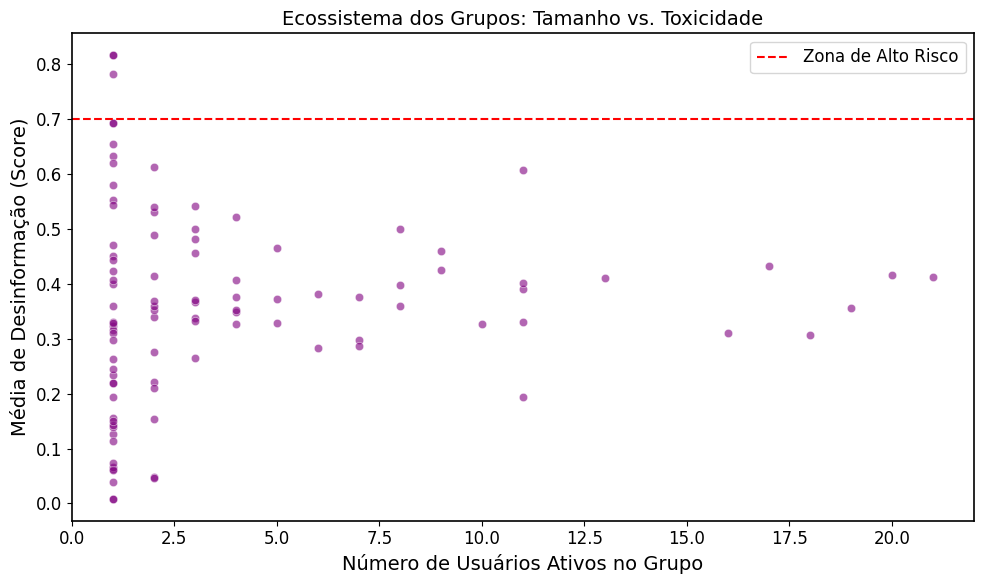

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 10. ANÁLISES FINAIS: TEMPORAL E ESTRUTURAL DE GRUPOS
# ==============================================================================

if 'df_full' in locals():
    print(">>> Iniciando Análise Temporal e de Grupos...")

    # Garante que temos data/hora
    # Tenta usar colunas comuns de timestamp. Ajuste se o nome for diferente.
    col_tempo = 'created_at' if 'created_at' in df_full.columns else 'date_message'
    
    # Converter para datetime
    df_full[col_tempo] = pd.to_datetime(df_full[col_tempo])
    
    # --------------------------------------------------------------------------
    # A. TIMELINE DA COORDENAÇÃO (QUANDO OCORREU?)
    # --------------------------------------------------------------------------
    print("Gerando gráfico de evolução temporal...")
    
    # Agrupar por Dia (ou Hora, se o período for curto. Use 'H' para hora, 'D' para dia)
    freq = 'D' 
    
    # 1. Volume Total de Mensagens (Background)
    vol_total = df_full.set_index(col_tempo).resample(freq).size()
    
    # 2. Volume de Mensagens Tóxicas/Coordenadas (Alta Desinformação)
    # Filtra mensagens que são coordenadas E têm score de desinformação alto
    mask_toxico = df_full['score_misinformation'] >= 0.7
    vol_toxico = df_full[mask_toxico].set_index(col_tempo).resample(freq).size()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(vol_total.index, vol_total.values, label='Volume Total', color='lightgray', linestyle='--')
    plt.plot(vol_toxico.index, vol_toxico.values, label='Msg Coordenada/Tóxica', color='red', linewidth=2)
    
    plt.title("Evolução Temporal: Atividade Total vs. Ataques Coordenados")
    plt.ylabel("Número de Mensagens")
    plt.xlabel("Data")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("timeline_coordenacao.png")
    plt.show()
    print("Gráfico salvo: 'timeline_coordenacao.png'")

    # --------------------------------------------------------------------------
    # B. PAPEL DOS GRUPOS (ONDE OCORREU?)
    # --------------------------------------------------------------------------
    print("\nGerando classificação dos grupos (Command Centers vs. Alvos)...")
    
    col_grupo = 'id_group_anonymous' # Ajuste se necessário
    
    if col_grupo in df_full.columns:
        # Para cada grupo, calculamos:
        # 1. Total de mensagens recebidas
        # 2. Total de usuários únicos
        # 3. Taxa de Desinformação (Média do score)
        
        stats_grupos = df_full.groupby(col_grupo).agg({
            'user_id': 'nunique',           # Quantas pessoas falam lá
            'clean_text': 'count',          # Volume de msgs
            'score_misinformation': 'mean'  # O quão tóxico é o grupo
        }).reset_index()
        
        stats_grupos.columns = ['Group_ID', 'Qtd_Usuarios', 'Vol_Msgs', 'Taxa_Desinfo']
        
        # Classificação Simples
        # Grupos Tóxicos: Alta Desinformação (> 0.7)
        # Grupos Populares: Muitos Usuários (> média)
        
        top_grupos_toxicos = stats_grupos.sort_values('Taxa_Desinfo', ascending=False).head(10)
        
        print("\n--- TOP 10 GRUPOS 'QUARTEL GENERAL' (Maior taxa de Fake News) ---")
        print(top_grupos_toxicos)
        
        # Salvar
        stats_grupos.to_csv("analise_grupos_metricas.csv", index=False)
        print("\nTabela de grupos salva em 'analise_grupos_metricas.csv'")
        
        # Gráfico de Dispersão: Tamanho do Grupo vs. Toxicidade
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=stats_grupos, x='Qtd_Usuarios', y='Taxa_Desinfo', alpha=0.6, color='purple')
        plt.axhline(0.7, color='red', linestyle='--', label='Zona de Alto Risco')
        plt.title("Ecossistema dos Grupos: Tamanho vs. Toxicidade")
        plt.xlabel("Número de Usuários Ativos no Grupo")
        plt.ylabel("Média de Desinformação (Score)")
        plt.legend()
        plt.tight_layout()
        plt.savefig("scatter_grupos.png")
        plt.show()

else:
    print("DF Full não carregado.")

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipysigma import Sigma

# ==============================================================================
# VISUALIZAÇÃO IPYSIGMA - CORRIGIDO (VERSÃO FINAL)
# ==============================================================================
print(">>> Gerando visualização estilo Gephi (ForceAtlas2)...")

if 'G' in locals() and 'partition' in locals():
    
    # 1. Preparação dos Dados
    nx.set_node_attributes(G, partition, 'comunidade')
    
    # Adicionar Grau Ponderado (Tamanho)
    weighted_degree = dict(G.degree(weight='Weight'))
    nx.set_node_attributes(G, weighted_degree, 'tamanho_grau')
    
    # 2. Filtragem (Componentes >= 3)
    components = [c for c in nx.connected_components(G) if len(c) >= 3]
    G_sigma = G.subgraph(set().union(*components))
    
    print(f"Renderizando {G_sigma.number_of_nodes()} nós e {G_sigma.number_of_edges()} arestas...")

    # 3. CRIAR MAPEAMENTO DE CORES MANUAL
    # Gera cores usando Matplotlib (tab20) e converte para HEX
    try:
        cmap = plt.get_cmap('tab20')
    except:
        cmap = plt.cm.tab20 

    unique_communities = set(partition.values())
    color_mapping = {}
    
    for comm_id in unique_communities:
        rgba = cmap(comm_id % 20)
        color_mapping[comm_id] = mcolors.to_hex(rgba)

    # 4. Renderizar com IPYSIGMA
    viz = Sigma(
        G_sigma, 
        
        # --- Aparência dos Nós ---
        node_size='tamanho_grau',
        node_color='comunidade',
        
        # --- CORREÇÃO FINAL AQUI ---
        # O argumento correto é 'node_color_palette', que aceita nosso dicionário
        node_color_palette=color_mapping, 
        
        # --- Layout ---
        start_layout='force_atlas2',
        layout_settings={
            'gravity': 1,
            'scalingRatio': 4, 
            'slowDown': 2
        },
        
        # --- Arestas ---
        edge_size='Weight',
        edge_color='#ccc',
        default_edge_type='curve',
        
        # --- Labels ---
        node_label_size='tamanho_grau', 
        label_font='sans-serif',
        
        # --- Widget ---
        height=800,
        background_color='#111111'
    )

    display(viz)
    print("Dica: Use o ícone de Câmera no canto inferior direito para salvar a imagem.")
    
else:
    print("ERRO: O Grafo G ou a partição não foram carregados.")


>>> Gerando visualização estilo Gephi (ForceAtlas2)...
Renderizando 133 nós e 124 arestas...


Sigma(nx.Graph with 133 nodes and 124 edges)

Dica: Use o ícone de Câmera no canto inferior direito para salvar a imagem.


In [28]:
from ipywidgets.embed import embed_minimal_html
import os

# ==============================================================================
# SALVAR VIA IPYWIDGETS (MÉTODO PADRÃO)
# ==============================================================================
print(">>> Exportando widget para HTML...")

filename = "rede_gephi_final.html"

try:
    # Esta função pega o widget 'viz' e cria um HTML standalone
    embed_minimal_html(filename, views=[viz], title='Rede de Coordenação WhatsApp')
    
    print(f"SUCESSO! Visualização salva em: {filename}")
    print("---------------------------------------------------------------")
    print(f"IMPORTANTE: Vá na pasta do seu projeto.")
    print(f"Abra o arquivo '{filename}' no navegador (Chrome/Edge/Firefox).")
    print("---------------------------------------------------------------")

    # Tenta abrir automaticamente (funciona no Windows)
    try:
        os.startfile(filename)
    except:
        pass

except Exception as e:
    print(f"Erro ao exportar: {e}")
    print("Verifique se 'ipywidgets' está instalado com: !pip install ipywidgets")

>>> Exportando widget para HTML...
✅ SUCESSO! Visualização salva em: rede_gephi_final.html
---------------------------------------------------------------
IMPORTANTE: Vá na pasta do seu projeto.
Abra o arquivo 'rede_gephi_final.html' no navegador (Chrome/Edge/Firefox).
---------------------------------------------------------------


In [29]:

ARQ_EDGES   = "p2_rede_coordenacao_final_07_60s.csv"   # Source, Target, Weight
ARQ_NODES   = "p2_nos_e_comunidades.csv"              # user_id, community_id, degree
ARQ_METRICS = "analise_grupos_metricas.csv"        # métricas por grupo (se quiser cruzar)

edges   = pd.read_csv(ARQ_EDGES)
nodes   = pd.read_csv(ARQ_NODES)
metrics = pd.read_csv(ARQ_METRICS)

print(edges.shape, nodes.shape, metrics.shape)
display(edges.head())
display(nodes.head())
display(metrics.head())

# ==== Monta grafo ponderado ====
G = nx.from_pandas_edgelist(edges, source="Source", target="Target", edge_attr="Weight", create_using=nx.Graph())
print("Nós:", G.number_of_nodes(), "Arestas:", G.number_of_edges())


(176, 3) (237, 3) (104, 4)


,Source,Target,Weight
0,8250dd2313ac20869bc7e9a604e407c2,f7b0a6233a9a639c4251c5ce42f9299d,9
1,f9a3713e47528edc24d8339e3722aee5,fac2d68f7a1e0334c7e57887818345ba,174
2,5bc42f808afaffc8c05bfceab9500ea0,f9a3713e47528edc24d8339e3722aee5,67
3,5bc42f808afaffc8c05bfceab9500ea0,fac2d68f7a1e0334c7e57887818345ba,168
4,a370b791e82b4937a50dc0de441122ae,f9a3713e47528edc24d8339e3722aee5,13


,user_id,community_id,degree
0,b6242381059f781a69bc6d7b4803c25b,13,7
1,36de514702d7b11e580390df7fbf4fc0,25,6
2,2b1282848e7c7bb897ae0605a7eb578a,25,6
3,0f601498e40c41072042d0f17974d3ba,13,6
4,e332627563f9ece81450ac03857d90ea,25,5


,Group_ID,Qtd_Usuarios,Vol_Msgs,Taxa_Desinfo
0,01b05f8760dea7589789b331479ef99d,1,7,0.782959
1,02279b9910329ca9ed5890aa58c68400,1,125,0.219519
2,04cd2bacf2ef6d56d4e8c0272752bbc0,18,1941,0.307111
3,12f61575080893f9c833b31b370e80e0,1,6,NaN
4,1342d65a3de7582a0d3a4b56a0e3ac29,1,118,0.194788


Nós: 237 Arestas: 176


In [30]:
# Core number (coreness) global
core_num = nx.core_number(G)  # dict: user_id -> k
nodes["coreness_global"] = nodes["user_id"].map(core_num).fillna(0).astype(int)

k_max = nodes["coreness_global"].max()
print("k_max (coreness máximo):", k_max)

# Regras de classificação (você pode ajustar):
# - Núcleo global: coreness >= k_max (mais estrito) OU >= k_max-1 (um pouco mais flexível)
nodes["is_core_global"] = (nodes["coreness_global"] >= k_max-1)

display(nodes.sort_values(["coreness_global","degree"], ascending=False).head(10))


k_max (coreness máximo): 2


,user_id,community_id,degree,coreness_global,is_core_global
0,b6242381059f781a69bc6d7b4803c25b,13,7,2,True
1,36de514702d7b11e580390df7fbf4fc0,25,6,2,True
3,0f601498e40c41072042d0f17974d3ba,13,6,2,True
4,e332627563f9ece81450ac03857d90ea,25,5,2,True
5,c5fff63b6151f93e1ce86d12f8acbee1,25,5,2,True
6,cebd2107ff2001db85851cc0e81e0667,13,5,2,True
7,a27ce2e80d07c12d6b7980bba16a06b3,13,5,2,True
9,ef496106907ece8b169c6219e5470b2c,2,4,2,True
10,37db16871b2131040560a1192fcbc244,25,4,2,True
11,ae628d3deb3b6078b6a514cde14aa580,13,4,2,True


In [31]:
def community_core_periphery(nodes_df, G, community_col="community_id", user_col="user_id"):
    out = []
    for cid, sub in nodes_df.groupby(community_col):
        users = sub[user_col].tolist()
        H = G.subgraph(users).copy()
        if H.number_of_nodes() < 3 or H.number_of_edges() == 0:
            # comunidade pequena/isolada: tudo vira periferia por definição
            tmp = sub.copy()
            tmp["coreness_comm"] = 0
            tmp["is_core_comm"] = False
            out.append(tmp)
            continue

        cnum = nx.core_number(H)
        tmp = sub.copy()
        tmp["coreness_comm"] = tmp[user_col].map(cnum).fillna(0).astype(int)
        kmax = tmp["coreness_comm"].max()

        # Núcleo comunitário: coreness_comm >= (kmax) ou (kmax-1)
        tmp["is_core_comm"] = (tmp["coreness_comm"] >= max(1, kmax-1))
        out.append(tmp)

    return pd.concat(out, ignore_index=True)

nodes2 = community_core_periphery(nodes, G)
display(nodes2.head())

# Resumo por comunidade: tamanho, densidade, % núcleo, coreness max
def community_summary(nodes_df, G):
    rows = []
    for cid, sub in nodes_df.groupby("community_id"):
        users = sub["user_id"].tolist()
        H = G.subgraph(users).copy()
        n = H.number_of_nodes()
        m = H.number_of_edges()
        density = nx.density(H) if n > 1 else 0

        rows.append({
            "community_id": cid,
            "n_users": n,
            "n_edges": m,
            "density": density,
            "kmax_comm": sub["coreness_comm"].max(),
            "core_frac_comm": sub["is_core_comm"].mean(),
            "avg_degree": sub["degree"].mean()
        })

    return pd.DataFrame(rows).sort_values(["n_users","n_edges"], ascending=False)

comm_stats = community_summary(nodes2, G)
display(comm_stats.head(10))

nodes2.to_csv("usuarios_core_periferia_por_comunidade_p1.csv", index=False)
print("Salvo: usuarios_core_periferia_por_comunidade.csv")

,user_id,community_id,degree,coreness_global,is_core_global,coreness_comm,is_core_comm
0,8250dd2313ac20869bc7e9a604e407c2,0,1,1,True,0,False
1,f7b0a6233a9a639c4251c5ce42f9299d,0,1,1,True,0,False
2,f9a3713e47528edc24d8339e3722aee5,1,3,2,True,2,True
3,fac2d68f7a1e0334c7e57887818345ba,1,2,2,True,2,True
4,5bc42f808afaffc8c05bfceab9500ea0,1,2,2,True,2,True


,community_id,n_users,n_edges,density,kmax_comm,core_frac_comm,avg_degree
25,25,30,31,0.071264,2,1.0,2.100000
13,13,29,32,0.078818,2,1.0,2.241379
41,41,7,6,0.285714,1,1.0,1.714286
2,2,6,7,0.466667,2,1.0,2.333333
9,9,5,5,0.500000,2,1.0,2.000000
5,5,5,4,0.400000,1,1.0,1.600000
29,29,5,4,0.400000,1,1.0,1.600000
31,31,5,4,0.400000,1,1.0,1.600000
1,1,4,4,0.666667,2,1.0,2.000000
6,6,4,3,0.500000,1,1.0,1.500000


Salvo: usuarios_core_periferia_por_comunidade.csv


In [32]:
# === Pluge aqui seu arquivo de localização ===
# Exemplo: usuarios_localizacao.csv com colunas user_id e ddd OU lat/lon
ARQ_LOC = "dataset_zap_2_preprocessado.csv"  # <- troque se necessário

try:
    loc = pd.read_csv(ARQ_LOC)
    display(loc.head())
except FileNotFoundError:
    loc = None
    print("Não achei usuarios_localizacao.csv. Sem ele não dá pra mapear DDD/lat-lon.")


C:\Users\nasci\AppData\Local\Temp\ipykernel_22612\53019615.py:6: DtypeWarning:

Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.



,id,date_message,id_member_anonymous,ddi,ddd,country,country_iso3,state,id_group_anonymous,media,...,messenger,media_name,media_md5,display_name,address_message,latitude_message,longitude_message,contacts_message,tokens_preprocessed,clean_text
0,1892572,2022-11-01 00:00:00.000000,b16837dd8b9dfc724bb7687d889ba492,55,81,BRAZIL,BRA,PE,e110071613239754d38878f7e046e95b,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0,0,NaN,"['filha', 'michelle', 'manifesta', 'após', 're...",filha michelle manifesta após resultado urnas ...
1,1892577,2022-11-01 00:00:18.000000,8782f8b429c19955446096559732d2b6,55,19,BRAZIL,BRA,SP,3f644cec57181e1b01bf3279d7480ee2,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0,0,NaN,"['pedir', 'intervenção', 'militar', 'federal',...",pedir intervenção militar federal manutenção p...
2,1892578,2022-11-01 00:00:17.000000,8782f8b429c19955446096559732d2b6,55,19,BRAZIL,BRA,SP,3f644cec57181e1b01bf3279d7480ee2,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0,0,NaN,"['pessoal', 'artigo', '142', 'diz', 'president...",pessoal artigo 142 diz presidente ficar 72h ca...
3,1892592,2022-11-01 00:01:33.000000,5e7cfe0a562abb5d46fef4f62de87ecb,55,32,BRAZIL,BRA,MG,3261942daa57e8575137153da98cdb21,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0,0,NaN,"['paralização', 'movimento', 'caminhoneiros', ...",paralização movimento caminhoneiros juiz mg in...
4,1892614,2022-11-01 00:05:59.000000,122a72945dc64c8d93e3c64a0a28699f,55,84,BRAZIL,BRA,RN,c14bc759ccabd4bfe70024d7f1cc49e3,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0,0,NaN,"['bancada', 'pl', 'consolida', 'maior', 'senad...",bancada pl consolida maior senado terrabrasiln...


In [33]:
# checar se os valores parecem bater
print(nodes2['user_id'].dtype, loc['id_member_anonymous'].dtype)
print(nodes2['user_id'].head(3).tolist())
print(loc['id_member_anonymous'].head(3).tolist())

# quantos users do nodes2 aparecem no loc?
overlap = set(nodes2['user_id']).intersection(set(loc['id_member_anonymous']))
print("Overlap users:", len(overlap), "de", nodes2['user_id'].nunique())


object object
['8250dd2313ac20869bc7e9a604e407c2', 'f7b0a6233a9a639c4251c5ce42f9299d', 'f9a3713e47528edc24d8339e3722aee5']
['b16837dd8b9dfc724bb7687d889ba492', '8782f8b429c19955446096559732d2b6', '8782f8b429c19955446096559732d2b6']
Overlap users: 237 de 237


In [34]:
loc_user = (
    loc.sort_values("date_message")
       .groupby("id_member_anonymous", as_index=False)
       .agg(
           latitude=("latitude", "last"),
           longitude=("longitude", "last"),
           ddd=("ddd", "last"),
           state=("state", "last"),
           country=("country", "last"),
       )
       .rename(columns={"id_member_anonymous": "user_id"})
)


In [35]:
loc_user = (
    loc.groupby("id_member_anonymous", as_index=False)
       .agg(
           latitude=("latitude", "median"),
           longitude=("longitude", "median"),
           ddd=("ddd", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
           state=("state", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
           country=("country", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
       )
       .rename(columns={"id_member_anonymous": "user_id"})
)


In [36]:
nodes_geo = nodes2.merge(loc_user, on="user_id", how="left")
display(nodes_geo.head())
print("Colunas disponíveis:", nodes_geo.columns.tolist())

print("Com lat/lon:", nodes_geo['latitude'].notna().sum(), "/", len(nodes_geo))
print("Com ddd:", nodes_geo['ddd'].notna().sum(), "/", len(nodes_geo))


,user_id,community_id,degree,coreness_global,is_core_global,coreness_comm,is_core_comm,latitude,longitude,ddd,state,country
0,8250dd2313ac20869bc7e9a604e407c2,0,1,1,True,0,False,-18.526484,-44.158865,31,MG,BRAZIL
1,f7b0a6233a9a639c4251c5ce42f9299d,0,1,1,True,0,False,-19.568768,-40.172199,27,ES,BRAZIL
2,f9a3713e47528edc24d8339e3722aee5,1,3,2,True,2,True,-23.550651,-46.633382,11,SP,BRAZIL
3,fac2d68f7a1e0334c7e57887818345ba,1,2,2,True,2,True,-18.526484,-44.158865,31,MG,BRAZIL
4,5bc42f808afaffc8c05bfceab9500ea0,1,2,2,True,2,True,19.432630,-99.133178,61,DF,BRAZIL


Colunas disponíveis: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm', 'latitude', 'longitude', 'ddd', 'state', 'country']
Com lat/lon: 237 / 237
Com ddd: 237 / 237


In [37]:
summary_comm = (
    nodes_geo.groupby("community_id", as_index=False)
             .agg(
                 n_users=("user_id", "nunique"),
                 n_core=("is_core_comm", "sum"),
                 core_ratio=("is_core_comm", "mean"),
                 median_coreness=("coreness_comm", "median"),
                 lat_ok=("latitude", lambda s: s.notna().sum()),
                 lon_ok=("longitude", lambda s: s.notna().sum()),
                 ddd_ok=("ddd", lambda s: s.notna().sum()),
             )
             .sort_values(["core_ratio","n_users"], ascending=False)
)
display(summary_comm.head(10))


,community_id,n_users,n_core,core_ratio,median_coreness,lat_ok,lon_ok,ddd_ok
25,25,30,30,1.0,1.0,30,30,30
13,13,29,29,1.0,1.0,29,29,29
41,41,7,7,1.0,1.0,7,7,7
2,2,6,6,1.0,2.0,6,6,6
5,5,5,5,1.0,1.0,5,5,5
9,9,5,5,1.0,2.0,5,5,5
29,29,5,5,1.0,1.0,5,5,5
31,31,5,5,1.0,1.0,5,5,5
1,1,4,4,1.0,2.0,4,4,4
6,6,4,4,1.0,1.0,4,4,4


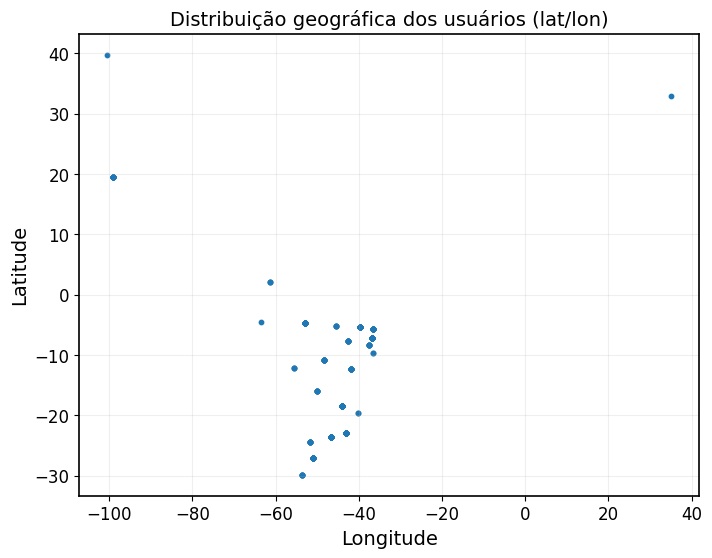

In [38]:
import matplotlib.pyplot as plt

tmp = nodes_geo.dropna(subset=["latitude","longitude"])

plt.figure(figsize=(8,6))
plt.scatter(tmp["longitude"], tmp["latitude"], s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribuição geográfica dos usuários (lat/lon)")
plt.grid(True, alpha=0.2)
plt.show()


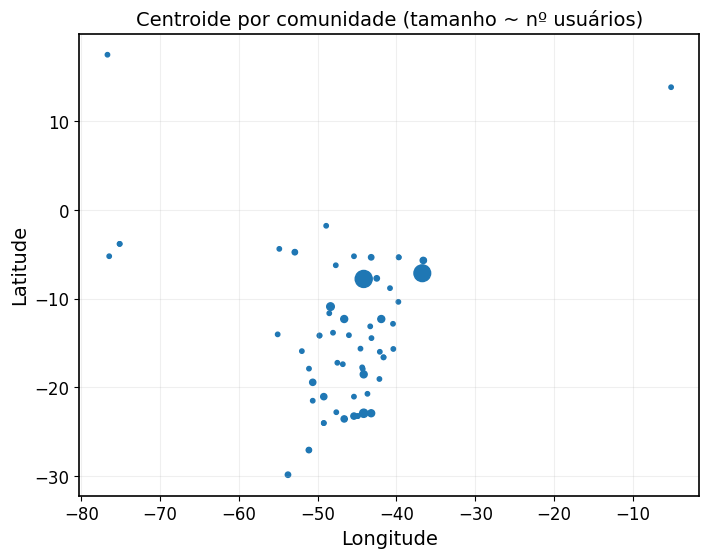

In [39]:
centroids = (
    tmp.groupby("community_id", as_index=False)
       .agg(
           n=("user_id","nunique"),
           lat=("latitude","median"),
           lon=("longitude","median"),
           core_ratio=("is_core_comm","mean")
       )
)

plt.figure(figsize=(8,6))
plt.scatter(centroids["lon"], centroids["lat"], s=centroids["n"]*5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Centroide por comunidade (tamanho ~ nº usuários)")
plt.grid(True, alpha=0.2)
plt.show()


In [40]:
ddd_stats = (
    nodes_geo.dropna(subset=["ddd"])
             .groupby("ddd", as_index=False)
             .agg(
                 n=("user_id","nunique"),
                 core_ratio=("is_core_global","mean")
             )
             .sort_values("n", ascending=False)
)

display(ddd_stats.head(20))


,ddd,n,core_ratio
43,83,30,1.0
1,11,27,1.0
8,21,15,1.0
44,84,11,1.0
45,85,11,1.0
28,61,11,1.0
30,63,8,1.0
14,34,8,1.0
22,47,7,1.0
12,31,7,1.0


In [41]:
nodes_geo = nodes2.merge(loc_user.rename(columns={"id_member_anonymous":"user_id"}), on="user_id", how="left")


In [42]:
nodes_geo = nodes2.merge(loc_user, on="user_id", how="left")


In [43]:
import pandas as pd
import numpy as np

# -----------------------------
# 0) Carregar
# -----------------------------

nodes2 = pd.read_csv("usuarios_core_periferia_por_comunidade_p1.csv")

# CORREÇÃO AQUI: Carregue o arquivo que contém os metadados (mensagens, ddd, estado)
# Não use o arquivo de rede/arestas aqui.
# Exemplo: Use o dataset preprocessado que contém as colunas de localização.
loc = pd.read_csv("dataset_zap_2_preprocessado.csv", low_memory=False)




# -----------------------------
# 1) Normalizar nomes de colunas (remove espaços/BOM)
# -----------------------------
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
        .astype(str)
        .str.replace("\ufeff", "", regex=False)  # remove BOM
        .str.strip()                              # remove espaços
    )
    return df

nodes2 = normalize_cols(nodes2)
loc = normalize_cols(loc)

print("nodes2 cols:", nodes2.columns.tolist())
print("loc cols:", loc.columns.tolist())

# -----------------------------
# 2) Garantir que nodes2 tem 'user_id'
# -----------------------------
if "user_id" not in nodes2.columns:
    raise ValueError(
        "nodes2 não tem a coluna 'user_id'. Veja as colunas acima e ajuste o nome "
        "ou renomeie (ex.: nodes2.rename(columns={'id_member_anonymous':'user_id'}) )."
    )

# -----------------------------
# 3) Descobrir automaticamente qual coluna em 'loc' corresponde ao usuário
# -----------------------------
candidates = [
    "id_member_anonymous",
    "id_member",
    "member_id",
    "user_id",
    "id_persona",
]

# tenta achar por igualdade exata
id_col = next((c for c in candidates if c in loc.columns), None)

# fallback: procura algo que contenha "member" e "anon"
if id_col is None:
    for c in loc.columns:
        cl = c.lower()
        if ("member" in cl and "anon" in cl) or (cl == "id_member_anonymous"):
            id_col = c
            break

# se ainda não achou, para com mensagem clara
if id_col is None:
    raise ValueError(
        "Não encontrei a coluna de usuário no 'loc'. "
        "Procurei por: "
        f"{candidates}. Colunas disponíveis: {loc.columns.tolist()}"
    )

print("✅ Coluna de usuário detectada em loc:", id_col)

# -----------------------------
# 4) Criar 'user_id' em loc e agregar por usuário
# -----------------------------
loc_users = loc.copy()
loc_users["user_id"] = loc_users[id_col].astype(str)

# escolha: usar lat/long da mensagem se existirem, senão lat/long geral
lat_col = "latitude_message" if "latitude_message" in loc_users.columns else ("latitude" if "latitude" in loc_users.columns else None)
lon_col = "longitude_message" if "longitude_message" in loc_users.columns else ("longitude" if "longitude" in loc_users.columns else None)

agg_dict = {
    "ddd": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
    "state": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
    "country": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
}

# só agrega lat/lon se existirem
if lat_col is not None and lon_col is not None:
    agg_dict[lat_col] = "median"
    agg_dict[lon_col] = "median"

loc_user_agg = (
    loc_users
    .groupby("user_id", as_index=False)
    .agg(agg_dict)
)

print("loc_user_agg cols:", loc_user_agg.columns.tolist())
print("Usuários únicos em loc_user_agg:", loc_user_agg["user_id"].nunique())

# -----------------------------
# 5) Merge final
# -----------------------------
nodes2["user_id"] = nodes2["user_id"].astype(str)
nodes_geo = nodes2.merge(loc_user_agg, on="user_id", how="left")

display(nodes_geo.head(10))

# -----------------------------
# 6) Diagnósticos
# -----------------------------
if "state" in nodes_geo.columns:
    print("Missing state:", nodes_geo["state"].isna().mean())
if "ddd" in nodes_geo.columns:
    print("Missing ddd:", nodes_geo["ddd"].isna().mean())

print("✅ nodes_geo cols:", nodes_geo.columns.tolist())


nodes2 cols: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm']
loc cols: ['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country', 'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media', 'has_media_url', 'trava_zap', 'text_content_anonymous', 'dataset_info_id', 'latitude', 'longitude', 'date_system', 'score_sentiment', 'score_misinformation', 'id_message', 'id_persona', 'message_type', 'messenger', 'media_name', 'media_md5', 'display_name', 'address_message', 'latitude_message', 'longitude_message', 'contacts_message', 'tokens_preprocessed', 'clean_text']
✅ Coluna de usuário detectada em loc: id_member_anonymous
loc_user_agg cols: ['user_id', 'ddd', 'state', 'country', 'latitude_message', 'longitude_message']
Usuários únicos em loc_user_agg: 8289


,user_id,community_id,degree,coreness_global,is_core_global,coreness_comm,is_core_comm,ddd,state,country,latitude_message,longitude_message
0,8250dd2313ac20869bc7e9a604e407c2,0,1,1,True,0,False,31,MG,BRAZIL,0.0,0.0
1,f7b0a6233a9a639c4251c5ce42f9299d,0,1,1,True,0,False,27,ES,BRAZIL,0.0,0.0
2,f9a3713e47528edc24d8339e3722aee5,1,3,2,True,2,True,11,SP,BRAZIL,0.0,0.0
3,fac2d68f7a1e0334c7e57887818345ba,1,2,2,True,2,True,31,MG,BRAZIL,0.0,0.0
4,5bc42f808afaffc8c05bfceab9500ea0,1,2,2,True,2,True,61,DF,BRAZIL,0.0,0.0
5,a370b791e82b4937a50dc0de441122ae,1,1,1,True,1,True,41,PR,BRAZIL,0.0,0.0
6,ef496106907ece8b169c6219e5470b2c,2,4,2,True,2,True,63,TO,BRAZIL,0.0,0.0
7,3bc964535b8e6bae52c2d9b8fcc73024,2,3,2,True,2,True,63,TO,BRAZIL,0.0,0.0
8,4ea1b3ee637da811b7d2d0df32db21f9,2,3,2,True,2,True,63,TO,BRAZIL,0.0,0.0
9,b66e161a06f8a08eafc03104846794df,2,2,2,True,2,True,63,TO,BRAZIL,0.0,0.0


Missing state: 0.0
Missing ddd: 0.0
✅ nodes_geo cols: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm', 'ddd', 'state', 'country', 'latitude_message', 'longitude_message']


In [44]:
# Trecho do seu notebook que precisa ser rodado antes
nodes_geo = nodes2.merge(loc_user_agg, on="user_id", how="left")

In [45]:
# -----------------------------------------------------------
# CORREÇÃO: Padronizar nomes das colunas de latitude/longitude
# -----------------------------------------------------------

print("Colunas atuais em nodes_geo:", nodes_geo.columns.tolist())

# Dicionário de possíveis nomes originais -> nome desejado
rename_map = {
    'latitude_message': 'latitude',
    'longitude_message': 'longitude',
    'lat': 'latitude',
    'lon': 'longitude',
    'lng': 'longitude',
    'long': 'longitude'
}

# Renomeia se encontrar alguma dessas variações
nodes_geo = nodes_geo.rename(columns=rename_map)

# Verificação final
if 'latitude' not in nodes_geo.columns or 'longitude' not in nodes_geo.columns:
    print("\n❌ ERRO CRÍTICO: As colunas de latitude/longitude ainda não foram encontradas.")
    print("Verifique se o arquivo 'dataset_zap_1_preprocessado.csv' (ou o que você usou no 'loc') realmente tem dados de GPS.")
else:
    print("\n✅ Colunas corrigidas! Prosseguindo para o mapa...")
    
    # -----------------------------------------------------------
    # AGORA SIM, O CÓDIGO DO MAPA (Repetindo o trecho que falhou)
    # -----------------------------------------------------------
    
    # Define Core/Periferia (se ainda não tiver definido)
    if 'role' not in nodes_geo.columns:
        limit_core = nodes_geo['degree'].quantile(0.80)
        nodes_geo['role'] = nodes_geo['degree'].apply(lambda x: 'core' if x >= limit_core else 'periphery')

    # Limpa dados nulos (agora deve funcionar)
    df_map = nodes_geo.dropna(subset=['latitude', 'longitude', 'state']).copy()
    
    print(f"Total de usuários plotáveis no mapa: {len(df_map)}")

    # (Aqui você pode rodar o restante do código dos mapas folium...)

Colunas atuais em nodes_geo: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm', 'ddd', 'state', 'country', 'latitude_message', 'longitude_message']

✅ Colunas corrigidas! Prosseguindo para o mapa...
Total de usuários plotáveis no mapa: 237


In [46]:
!pip install geopandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import pandas as pd

df = pd.read_csv("dataset_zap_2_preprocessado.csv")

# garante que existe a coluna state
print(df.columns.tolist())

estado_tipo = (
    df.groupby("state")
      .size()
      .reset_index(name="qtd_msg")
)

estado_tipo["state"] = estado_tipo["state"].astype(str).str.upper()

print(estado_tipo.head())


['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country', 'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media', 'has_media_url', 'trava_zap', 'text_content_anonymous', 'dataset_info_id', 'latitude', 'longitude', 'date_system', 'score_sentiment', 'score_misinformation', 'id_message', 'id_persona', 'message_type', 'messenger', 'media_name', 'media_md5', 'display_name', 'address_message', 'latitude_message', 'longitude_message', 'contacts_message', 'tokens_preprocessed', 'clean_text']
  state  qtd_msg
0    AC       94
1    AL     1499
2    AM     3962
3    AP       71
4    BA     7465


C:\Users\nasci\AppData\Local\Temp\ipykernel_22612\3356793068.py:3: DtypeWarning:

Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.



In [50]:
import geopandas as gpd

# 1. Carregar o arquivo
br_states = gpd.read_file(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
)

# 2. Verificação (Diagnóstico)
print("Colunas encontradas no GeoJSON:", br_states.columns.tolist())

# 3. Tratamento da coluna de Estado
if 'sigla' in br_states.columns:
    print("Coluna 'sigla' já existe!")
    br_states['sigla'] = br_states['sigla'].str.upper()
else:
    print("Criando sigla a partir do nome...")
    estado_to_sigla = {
        'ACRE': 'AC', 'ALAGOAS': 'AL', 'AMAPÁ': 'AP', 'AMAZONAS': 'AM', 'BAHIA': 'BA', 'CEARÁ': 'CE',
        'DISTRITO FEDERAL': 'DF', 'ESPÍRITO SANTO': 'ES', 'GOIÁS': 'GO', 'MARANHÃO': 'MA', 'MATO GROSSO': 'MT',
        'MATO GROSSO DO SUL': 'MS', 'MINAS GERAIS': 'MG', 'PARÁ': 'PA', 'PARAÍBA': 'PB', 'PARANÁ': 'PR',
        'PERNAMBUCO': 'PE', 'PIAUÍ': 'PI', 'RIO DE JANEIRO': 'RJ', 'RIO GRANDE DO NORTE': 'RN',
        'RIO GRANDE DO SUL': 'RS', 'RONDÔNIA': 'RO', 'RORAIMA': 'RR', 'SANTA CATARINA': 'SC',
        'SÃO PAULO': 'SP', 'SERGIPE': 'SE', 'TOCANTINS': 'TO'
    }

    # ajuste: muitos geojson usam 'name' ou 'NAME'
    name_col = 'name' if 'name' in br_states.columns else ('NAME' if 'NAME' in br_states.columns else None)
    if name_col is None:
        raise KeyError("Não achei coluna de nome do estado no GeoJSON (ex: 'name' ou 'NAME').")

    br_states['name_upper'] = br_states[name_col].str.upper()
    br_states['sigla'] = br_states['name_upper'].map(estado_to_sigla)

# 4. Merge (garantindo que estado_tipo existe)
# estado_tipo deve ter colunas: 'state' (sigla) e o(s) valor(es) que você quer plotar
br_states = br_states.merge(estado_tipo, how='left', left_on='sigla', right_on='state')

# preenche apenas colunas numéricas com 0 (melhor que fillna geral)
num_cols = br_states.select_dtypes(include="number").columns
br_states[num_cols] = br_states[num_cols].fillna(0)

print("✅ Merge concluído com sucesso!")

Colunas encontradas no GeoJSON: ['id', 'name', 'sigla', 'regiao_id', 'codigo_ibg', 'cartodb_id', 'created_at', 'updated_at', 'geometry']
Coluna 'sigla' já existe!
✅ Merge concluído com sucesso!


In [ ]:
print(br_states.columns)

In [53]:
# ==============================================================================
# PASSO FINAL: GERAR E SALVAR OS MAPAS
# ==============================================================================
import folium


# 1. Garantir que temos o DataFrame limpo para os pontos (sem lat/lon nulos)
# Caso não tenha feito antes:
df_map = nodes_geo.dropna(subset=['latitude', 'longitude', 'state']).copy()

# ------------------------------------------------------------------------------
# MAPA 1: DENSIDADE POR ESTADO (Coroplético)
# ------------------------------------------------------------------------------
print("Gerando Mapa 1: Densidade por Estado...")

m1 = folium.Map(location=[-14.2, -51.9], zoom_start=4)

# Camada: Quantidade de usuários do NÚCLEO (Core)
folium.Choropleth(
    geo_data=br_states,
    data=br_states,
    columns=["sigla", "core"],        # Colunas no GeoDataFrame (br_states)
    key_on="feature.properties.sigla", # Caminho no JSON do mapa
    fill_color="YlOrRd",              # Amarelo -> Laranja -> Vermelho
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Qtd Usuários Núcleo (Core)",
    name="Núcleo"
).add_to(m1)

# Camada: Quantidade de usuários da PERIFERIA (Opcional, começa oculta)
folium.Choropleth(
    geo_data=br_states,
    data=br_states,
    columns=["sigla", "periphery"],
    key_on="feature.properties.sigla",
    fill_color="YlGnBu",              # Amarelo -> Verde -> Azul
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Qtd Usuários Periferia",
    name="Periferia",
    show=False                        # Usuário precisa ativar no menu
).add_to(m1)

# Adiciona controle de camadas (Layer Control)
folium.LayerControl().add_to(m1)

# Salvar
m1.save("p2_mapa_densidade_estados.html")
print("✅ 'mapa_densidade_estados.html' salvo com sucesso!")
display(m1) # Mostra no notebook

# ------------------------------------------------------------------------------
# MAPA 2: CLUSTERS DE PONTOS (Zoom interativo)
# ------------------------------------------------------------------------------
print("\nGerando Mapa 2: Clusters de Usuários...")

m2 = folium.Map(location=[-14.2, -51.9], zoom_start=4)

# Definição de cores
colors = {'core': 'red', 'periphery': 'blue'}

for tipo, cor in colors.items():
    # Filtra apenas o tipo atual
    sub_df = df_map[df_map['role'] == tipo]
    
    # Cria o agrupador (Cluster)
    cluster = MarkerCluster(name=f"Usuários {tipo.capitalize()}").add_to(m2)
    
    # Adiciona cada ponto ao cluster
    # (Usando list comprehension para ser mais rápido que iterrows)
    for lat, lon, uid, comm in zip(sub_df['latitude'], sub_df['longitude'], sub_df['user_id'], sub_df['community_id']):
        folium.CircleMarker(
            location=(lat, lon),
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.7,
            popup=f"<b>User:</b> {uid}<br><b>Comunidade:</b> {comm}<br><b>Tipo:</b> {tipo}"
        ).add_to(cluster)

folium.LayerControl().add_to(m2)

# Salvar
m2.save("mapa_usuarios_clusters.html")
print("✅ 'mapa_usuarios_clusters.html' salvo com sucesso!")
display(m2)

Gerando Mapa 1: Densidade por Estado...


KeyError: 'core'

In [ ]:
# ==============================================================================
# PASSO FINAL: GERAR E SALVAR OS MAPAS
# ==============================================================================

# 1. Garantir que temos o DataFrame limpo para os pontos (sem lat/lon nulos)
# Caso não tenha feito antes:
df_map = nodes_geo.dropna(subset=['latitude', 'longitude', 'state']).copy()

# ------------------------------------------------------------------------------
# MAPA 1: DENSIDADE POR ESTADO (Coroplético)
# ------------------------------------------------------------------------------
print("Gerando Mapa 1: Densidade por Estado...")

m1 = folium.Map(location=[-14.2, -51.9], zoom_start=4)

# Camada: Quantidade de usuários do NÚCLEO (Core)
folium.Choropleth(
    geo_data=br_states,
    data=br_states,
    columns=["sigla", "core"],        # Colunas no GeoDataFrame (br_states)
    key_on="feature.properties.sigla", # Caminho no JSON do mapa
    fill_color="YlOrRd",              # Amarelo -> Laranja -> Vermelho
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Qtd Usuários Núcleo (Core)",
    name="Núcleo"
).add_to(m1)

# Camada: Quantidade de usuários da PERIFERIA (Opcional, começa oculta)
folium.Choropleth(
    geo_data=br_states,
    data=br_states,
    columns=["sigla", "periphery"],
    key_on="feature.properties.sigla",
    fill_color="YlGnBu",              # Amarelo -> Verde -> Azul
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Qtd Usuários Periferia",
    name="Periferia",
    show=False                        # Usuário precisa ativar no menu
).add_to(m1)

# Adiciona controle de camadas (Layer Control)
folium.LayerControl().add_to(m1)

# Salvar
m1.save("mapa_densidade_estados.html")
print("✅ 'mapa_densidade_estados.html' salvo com sucesso!")
display(m1) # Mostra no notebook

# ------------------------------------------------------------------------------
# MAPA 2: CLUSTERS DE PONTOS (Zoom interativo)
# ------------------------------------------------------------------------------
print("\nGerando Mapa 2: Clusters de Usuários...")

m2 = folium.Map(location=[-14.2, -51.9], zoom_start=4)

# Definição de cores
colors = {'core': 'red', 'periphery': 'blue'}

for tipo, cor in colors.items():
    # Filtra apenas o tipo atual
    sub_df = df_map[df_map['role'] == tipo]
    
    # Cria o agrupador (Cluster)
    cluster = MarkerCluster(name=f"Usuários {tipo.capitalize()}").add_to(m2)
    
    # Adiciona cada ponto ao cluster
    # (Usando list comprehension para ser mais rápido que iterrows)
    for lat, lon, uid, comm in zip(sub_df['latitude'], sub_df['longitude'], sub_df['user_id'], sub_df['community_id']):
        folium.CircleMarker(
            location=(lat, lon),
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.7,
            popup=f"<b>User:</b> {uid}<br><b>Comunidade:</b> {comm}<br><b>Tipo:</b> {tipo}"
        ).add_to(cluster)

folium.LayerControl().add_to(m2)

# Salvar
m2.save("mapa_usuarios_clusters.html")
print("✅ 'mapa_usuarios_clusters.html' salvo com sucesso!")
display(m2)

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors

# ==============================================================================
# 1. CORREÇÃO DO ERRO DE DATA (JSON SERIALIZABLE)
# ==============================================================================
def clean_df_for_map(df):
    """Converte datas para string e remove nulos de lat/lon"""
    df_clean = df.copy()
    
    # Converter datas para string
    for col in df_clean.columns:
        if pd.api.types.is_datetime64_any_dtype(df_clean[col]):
            df_clean[col] = df_clean[col].astype(str)
            
    # Remover quem não tem lat/lon
    df_clean = df_clean.dropna(subset=['latitude', 'longitude'])
    return df_clean

# Aplicar a limpeza
df_map = clean_df_for_map(nodes_geo)

print(f"Usuários prontos para o mapa: {len(df_map)}")

# ==============================================================================
# 2. CONFIGURAÇÃO DE CORES POR COMUNIDADE
# ==============================================================================
# Pega as top 20 comunidades para dar cores distintas, o resto fica cinza
top_communities = df_map['community_id'].value_counts().head(20).index.tolist()

# Gera uma paleta de cores (arco-íris)
cmap = cm.get_cmap('tab20', len(top_communities))

def get_color(comm_id):
    if comm_id in top_communities:
        # Converte cor do matplotlib para Hexadecimal (ex: #FF0000)
        idx = top_communities.index(comm_id)
        rgba = cmap(idx)
        return colors.to_hex(rgba)
    else:
        return '#808080' # Cinza para comunidades pequenas

# ==============================================================================
# 3. GERAR O MAPA DE COMUNIDADES E LIDERANÇAS
# ==============================================================================
m = folium.Map(location=[-14.2, -51.9], zoom_start=4, tiles="cartodbpositron")

# --- GRUPO 1: Usuários Comuns (Periferia) - Bolinhas Pequenas ---
# Usamos MarkerCluster para não travar o mapa com muitos pontos
cluster_periferia = MarkerCluster(name="Usuários (Periferia)").add_to(m)

# --- GRUPO 2: Usuários Principais (Core/Núcleo) - Marcadores de Destaque ---
# Estes ficam visíveis sem precisar clicar em cluster (ou em um cluster separado)
cluster_core = MarkerCluster(name="🔥 Principais Usuários (Core)").add_to(m)

print("Gerando pontos no mapa...")

for _, row in df_map.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    comm = row['community_id']
    role = row.get('role', 'periphery') # Se não tiver role, assume periferia
    uid = row['user_id']
    ddd = row.get('ddd', 'N/A')
    
    cor_comunidade = get_color(comm)
    
    popup_txt = f"""
    <b>User ID:</b> {uid}<br>
    <b>Comunidade:</b> {comm}<br>
    <b>DDD:</b> {ddd}<br>
    <b>Papel:</b> {role.upper()}
    """
    
    # LÓGICA DE PLOTAGEM
    if role == 'core':
        # USUÁRIO PRINCIPAL: Ganha um ícone de estrela e borda preta
        folium.Marker(
            location=[lat, lon],
            popup=popup_txt,
            icon=folium.Icon(color='red', icon='star', prefix='fa'), # Ícone de estrela
            tooltip=f"Líder Com. {comm}"
        ).add_to(cluster_core)
        
        # Opcional: Adicionar também um círculo colorido por baixo para ver a comunidade
        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            color='black',
            weight=2,
            fill=True,
            fill_color=cor_comunidade,
            fill_opacity=1
        ).add_to(cluster_core)
        
    else:
        # USUÁRIO COMUM: Apenas uma bolinha colorida pela comunidade
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=cor_comunidade,
            fill=True,
            fill_color=cor_comunidade,
            fill_opacity=0.6,
            popup=popup_txt
        ).add_to(cluster_periferia)

# Adicionar controle de camadas para ligar/desligar Core ou Periferia
folium.LayerControl().add_to(m)

# Salvar e Exibir
arquivo_saida = "mapa_estrategico_comunidades.html"
m.save(arquivo_saida)
print(f"✅ Mapa salvo em: {arquivo_saida}")
display(m)

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster, HeatMap
import matplotlib.cm as cm
import matplotlib.colors as colors

# ==============================================================================
# 0. PREPARAÇÃO E LIMPEZA DOS DADOS
# ==============================================================================
# Garantir que lat/lon sejam números e remover erros
df_map = nodes_geo.copy()
df_map['latitude'] = pd.to_numeric(df_map['latitude'], errors='coerce')
df_map['longitude'] = pd.to_numeric(df_map['longitude'], errors='coerce')
df_map = df_map.dropna(subset=['latitude', 'longitude'])

# Garantir que datas virem string (evita erro de JSON)
for col in df_map.columns:
    if pd.api.types.is_datetime64_any_dtype(df_map[col]):
        df_map[col] = df_map[col].astype(str)

print(f"Total de pontos válidos para os mapas: {len(df_map)}")

# ==============================================================================
# MAPA 1: NÚCLEO (Líderes) vs PERIFERIA
# ==============================================================================
print("Gerando Mapa 1: Core vs Periferia...")
m1 = folium.Map(location=[-14.2, -51.9], zoom_start=4, tiles="cartodbpositron")

# Cluster para Periferia (Azul) - Agrupa para não travar
cluster_periferia = MarkerCluster(name="Periferia (Massa)").add_to(m1)
# Cluster para Core (Vermelho) - Destaque
cluster_core = MarkerCluster(name="Núcleo (Líderes)").add_to(m1)

for lat, lon, role, uid, ddd in zip(df_map['latitude'], df_map['longitude'], df_map['role'], df_map['user_id'], df_map.get('ddd', 'N/A')):
    
    popup_txt = f"User: {uid}<br>DDD: {ddd}"
    
    if role == 'core':
        folium.CircleMarker(
            location=[lat, lon], radius=7, color='red', fill=True, fill_color='red', fill_opacity=0.8,
            popup=f"{popup_txt}<br>Status: CORE"
        ).add_to(cluster_core)
    else:
        folium.CircleMarker(
            location=[lat, lon], radius=4, color='blue', fill=True, fill_color='blue', fill_opacity=0.5,
            popup=f"{popup_txt}<br>Status: Periferia"
        ).add_to(cluster_periferia)

folium.LayerControl().add_to(m1)
m1.save("mapa_1_core_periferia.html")
print("✅ Salvo: mapa_1_core_periferia.html")

# ==============================================================================
# MAPA 2: COMUNIDADES (Colorido por Grupo)
# ==============================================================================
print("Gerando Mapa 2: Comunidades...")
m2 = folium.Map(location=[-14.2, -51.9], zoom_start=4, tiles="cartodbpositron")

# Configurar cores para as Top 20 comunidades
top_comm = df_map['community_id'].value_counts().head(20).index.tolist()
cmap = cm.get_cmap('tab20', len(top_comm))

def get_color(comm_id):
    if comm_id in top_comm:
        return colors.to_hex(cmap(top_comm.index(comm_id)))
    return '#808080' # Cinza para comunidades menores

# Cria um cluster único para organizar os pontos
cluster_comm = MarkerCluster(name="Comunidades").add_to(m2)

for lat, lon, comm, uid in zip(df_map['latitude'], df_map['longitude'], df_map['community_id'], df_map['user_id']):
    cor = get_color(comm)
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=cor,
        fill=True,
        fill_color=cor,
        fill_opacity=0.7,
        popup=f"Comunidade: {comm}<br>User: {uid}"
    ).add_to(cluster_comm)

folium.LayerControl().add_to(m2)
m2.save("mapa_2_comunidades.html")
print("✅ Salvo: mapa_2_comunidades.html")

# ==============================================================================
# MAPA 3: DENSIDADE GERAL (Heatmap de Usuários)
# ==============================================================================
print("Gerando Mapa 3: Densidade de Usuários (Heatmap)...")
m3 = folium.Map(location=[-14.2, -51.9], zoom_start=4, tiles="cartodbpositron")

# Prepara dados para o Heatmap [[lat, lon], [lat, lon], ...]
heat_data = df_map[['latitude', 'longitude']].values.tolist()

HeatMap(heat_data, radius=15, blur=10).add_to(m3)

m3.save("mapa_3_densidade_geral.html")
print("✅ Salvo: mapa_3_densidade_geral.html")

print("\n--- PROCESSO CONCLUÍDO! Verifique os arquivos na pasta. ---")

In [ ]:
import pandas as pd
import numpy as np

# 1. Seleção e Limpeza dos Dados
# Vamos garantir que pegamos apenas o necessário do 'nodes_geo'
cols_desejadas = [
    'user_id', 
    'community_id', 
    'role',        # core ou periphery
    'latitude', 
    'longitude', 
    'state', 
    'ddd'
]

# Verifica se a coluna 'degree' existe (útil para tamanho da bolinha no D3)
if 'degree' in nodes_geo.columns:
    cols_desejadas.append('degree')

# Cria o DataFrame de exportação
export_df = nodes_geo[cols_desejadas].copy()

# Converte Lat/Lon para numérico e remove erros
export_df['latitude'] = pd.to_numeric(export_df['latitude'], errors='coerce')
export_df['longitude'] = pd.to_numeric(export_df['longitude'], errors='coerce')
export_df = export_df.dropna(subset=['latitude', 'longitude'])

# Remove colunas que podem ser NaN ou converte para string vazia/neutra
export_df['state'] = export_df['state'].fillna('')
export_df['ddd'] = export_df['ddd'].fillna(0).astype(int)

# 2. Exportar para CSV (Universal)
csv_filename = "dados_geograficos_rede.csv"
export_df.to_csv(csv_filename, index=False, encoding='utf-8')
print(f"✅ Arquivo CSV gerado: {csv_filename}")

# 3. Exportar para JSON (Formato Array de Objetos para D3.js)
# O formato 'records' gera: [{"user_id": 1, "lat": -23...}, {"user_id": 2...}]
json_filename = "dados_geograficos_rede.json"
export_df.to_json(json_filename, orient='records', indent=2)
print(f"✅ Arquivo JSON gerado: {json_filename}")

# Amostra de como os dados ficaram
print("\n--- Amostra dos dados (Primeiras 3 linhas) ---")
print(export_df.head(3).to_dict(orient='records'))

In [ ]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PREPARAÇÃO ROBUSTA (Corrigindo o erro '1-978')
# ==============================================================================
print("Iniciando limpeza dos dados...")

# Define colunas desejadas
cols_desejadas = ['user_id', 'community_id', 'role', 'latitude', 'longitude', 'state', 'ddd']
if 'degree' in nodes_geo.columns:
    cols_desejadas.append('degree')

export_df = nodes_geo[cols_desejadas].copy()

# --- CORREÇÃO PRINCIPAL AQUI ---
# 1. Limpa DDD: Transforma '1-978' e textos estranhos em NaN, depois preenche com 0
export_df['ddd'] = pd.to_numeric(export_df['ddd'], errors='coerce').fillna(0).astype(int)

# 2. Limpa Community_ID: Garante que seja inteiro também
export_df['community_id'] = pd.to_numeric(export_df['community_id'], errors='coerce').fillna(-1).astype(int)

# 3. Limpa Lat/Lon
export_df['latitude'] = pd.to_numeric(export_df['latitude'], errors='coerce')
export_df['longitude'] = pd.to_numeric(export_df['longitude'], errors='coerce')

# Remove quem não tem GPS válido
export_df = export_df.dropna(subset=['latitude', 'longitude'])

# 4. Limpa Estado
export_df['state'] = export_df['state'].fillna('N/A').astype(str)

print(f"✅ Dados limpos! Usuários válidos: {len(export_df)}")
print("-" * 60)

# ==============================================================================
# 2. PRINTS DE VERIFICAÇÃO (Para você conferir)
# ==============================================================================

# Verifica se sobrou algum DDD estranho (deve ser tudo número agora)
print("Amostra de DDDs processados:", export_df['ddd'].unique()[:10])

# Top 10 Líderes
print("\n>>> Top 10 Líderes (Core):")
if 'degree' in export_df.columns:
    top_core = export_df[export_df['role'] == 'core'].sort_values('degree', ascending=False).head(10)
else:
    top_core = export_df[export_df['role'] == 'core'].head(10)
    
print(top_core[['user_id', 'community_id', 'state', 'ddd']].to_string(index=False))

# ==============================================================================
# 3. EXPORTAÇÃO
# ==============================================================================
export_df.to_csv("dados_geograficos_rede.csv", index=False, encoding='utf-8')
export_df.to_json("dados_geograficos_rede.json", orient='records', indent=2)

print("\n✅ Arquivos 'dados_geograficos_rede.csv' e '.json' gerados com sucesso!")